In [1]:
import numpy as np
from envs import MarsExplorerEnv
import matplotlib.pyplot as plt
import time
import matplotlib.cm as cm
import matplotlib.colors as colors
import os
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib._png import read_png
%matplotlib inline

import gym
from gym import spaces
from gym.envs.classic_control import rendering
import tensorflow as tf
from scipy.special import logsumexp
from copy import deepcopy as copy
import random
np.set_printoptions(precision=8, suppress=True,threshold=np.nan)

In [28]:
%store -r

In [ ]:
#%store

In [3]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
NOOP = 4

cdict = {'red':   ((0.0,  0.173, 0.173),
                   (1.0,  0.925, 0.925)),

         'green': ((0.0,  0.067, 0.067),
                   (1.0, 0.384, 0.384)),

         'blue':  ((0.0,  0.027, 0.027),
                   (1.0,  0.196, 0.196))}
plt.register_cmap(name='RustPlanet', data=cdict)
REWARD_COLORS = cm.get_cmap('RustPlanet')
AGENT_COLORS = cm.get_cmap('gray')
MAP_COLORS = {b'B':"#3a0e00",
              b'F':"#933111",
              b'S':"#933111",
              b'U':"#d65b33",
              b'1':"#956F52",
              b'2':"#3C2F34",
              b'3':"#644C42"}

ROVER_PNGS = {LEFT:"utils/rover_left.png",
        RIGHT:"utils/rover_right.png",
        DOWN:"utils/rover_down.png",
        UP:"utils/rover_up.png",
        NOOP:"utils/rover_sample.png"}

# tile_map = [
#         "F3FFUFU2U",
#         "FUFUSUFUF",
#         "FFFUSUFFU",
#         "USUUUUUSU",
#         "FFUSSSUFF",
#         "FSFUSUFSF",
#         "UUUUUUUFU",
#         "UFFU1UFUU",
#         "3UUFUFFU1"
#     ]

tile_map = [
        "F22222FF1",
        "U31122FU1",
        "UF1112FU1",
        "UFUU1SFU1",
        "UFFU1FFU3",
        "3222UFS1U",
        "UUU22F1FU",
        "FSSFS12SF",
        "FSFF121FF",
        "S1S2SFFSF",
        "FUUUFFSFU",
        "UF3UUFSFU",
        "UFFFUFUUU"
    ]

# tile_map = [
#         "3FFFFFFF1",
#         "FFFFFFFFF",
#         "FFFFUFFFF",
#         "FSFUUUFSF",
#         "FSUU3UUSF",
#         "FSFUUUFSF",
#         "FFFFUFFFF",
#         "FFFSSSFFF",
#         "1FFFFFFF2"
#     ]

tile_rewards = {'F':0.05,
              '1':0.1,
              '2':0.2,
              '3':0.3,
              'S':0.01,
              'U':0.0}


goal_tile_rewards = {'F':0.0,
              '1':1.0,
              '2':2.0,
              '3':4.0,
              'S':0.0,
              'U':0.0}

tile_reward_modifier = lambda r,x,y,mx,my: r * 0.2 * (42 - (x-(mx/2 + np.random.normal())**2 - (y - (mx/2 + np.random.normal()))**2))

def build_reward_map(tile_map, tile_rewards, goal_tile_rewards, tile_reward_modifier):
    reward_map = np.zeros((len(tile_map),len(tile_map[0])))
    texture_map = np.zeros((len(tile_map),len(tile_map[0])))
    for y,row in enumerate(tile_map):
        for x,c in enumerate(row):
            reward_map[y,x] = texture_map[y,x] = tile_reward_modifier(tile_rewards[c],x,y,len(tile_map[0]),len(tile_map))
            reward_map[y,x] +=  goal_tile_rewards[c]
    return reward_map, texture_map

reward_map, texture_map = build_reward_map(tile_map, tile_rewards, goal_tile_rewards, tile_reward_modifier)


t0 = (0.8,0.1,0.0,0.0)
t1 = (0.0,0.0,0.0,1.0)  #(0.1,0.15,0.5,0.1)

trans_dict = {b'F':t0,
              b'1':t0,
              b'2':t0,
              b'3':t0,
              b'S':t0,
              b'U':t1}

gamma = 0.98

alpha = 0.0001

T_theta_shape = (5,5,2)

time_penalty = 0.0


In [5]:
reward_normalizer = (1-gamma)/(np.max(reward_map))
reward_map *= reward_normalizer
time_penalty *= reward_normalizer

In [6]:
temperature = 1/(reward_normalizer)
print(temperature)

496.2953853335332


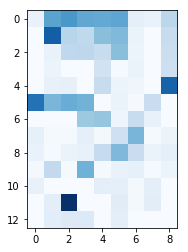

In [7]:
plt.imshow(reward_map, cmap="Blues")

In [8]:
mdp = MarsExplorerEnv(tile_map, reward_map, texture_map, trans_dict, time_penalty) 
nA = mdp.nA
nS = mdp.nS

In [9]:
print(mdp.tile_map.flatten()[43])

b'U'


In [10]:
def plot_mars(mdp, pi, term = 40, title=None, counts = None, Qs = None):
    background = np.array([colors.to_rgb(MAP_COLORS[l]) for l in mdp.tile_map.flat]).reshape(mdp.nrow, mdp.ncol,3)
    s = mdp._reset()
    t, r = 0, 0
    while s is not None and t < term:
        fig = plt.figure(figsize=(4,4))
        if title != None:
            plt.title(title)
        plt.imshow(background)
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        ax = plt.gca()
        a = pi[s] if type(pi) == np.ndarray else pi(s)
        img_path = ROVER_PNGS[a]
        arr_hand = read_png(img_path)
        imagebox = OffsetImage(arr_hand, zoom=.5)
        xy = [s%background.shape[1], s//background.shape[1]]  # coordinates to position this image

        ab = AnnotationBbox(imagebox, xy,
                            xybox=(0, 0),
                            xycoords='data',
                            boxcoords="offset points",
                            frameon=False)
        ax.add_artist(ab)
        fig.text(0.13, 0.05, 't: {}      r: {}'.format(t,round(r,4)), ha='left', fontsize=10)
        sns.despine(bottom=True,left=True,right=True,top=True)
        plt.show()
        if Qs is not None:
            print(Qs[s])
            print(a)
            print(softmax(Qs[s] * temperature))
        print(mdp.s_to_grid(s), mdp.tile_map.flatten()[s])
        s, rt, _, d = mdp._step(a)
        print(mdp.s_to_grid(s), mdp.tile_map.flatten()[s])
        t += 1
        r += rt
    if counts:
        fig.text(0.87, 0.05, 'F: {}  L/R: {}  B: {}  S: {}'.format(counts['F'], counts['LR'], counts['B'], counts['S']), ha='right', fontsize=10)
    #     plt.savefig(folder+"/"+str(t)+".png", format='png')
    return

def plot_mars_history(mdp, hist, title=None, counts = None):
    background = np.array([colors.to_rgb(MAP_COLORS[l]) for l in mdp.tile_map.flat]).reshape(mdp.nrow, mdp.ncol,3)
    t = 0
    for s,a,sprime in [h[0] for h in hist]:
        fig = plt.figure(figsize=(4,4))
        if title != None:
            plt.title(title)
        plt.imshow(background)
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        ax = plt.gca()
        img_path = ROVER_PNGS[a]
        arr_hand = read_png(img_path)
        imagebox = OffsetImage(arr_hand, zoom=.5)
        xy = [s%background.shape[1], s//background.shape[1]]  # coordinates to position this image

        ab = AnnotationBbox(imagebox, xy,
                            xybox=(0, 0),
                            xycoords='data',
                            boxcoords="offset points",
                            frameon=False)
        ax.add_artist(ab)
        fig.text(0.13, 0.05, 't: {}'.format(t), ha='left', fontsize=10)
        sns.despine(bottom=True,left=True,right=True,top=True)
        plt.show()
        t += 1
    if counts:
        fig.text(0.87, 0.05, 'F: {}  L/R: {}  B: {}  S: {}'.format(counts['F'], counts['LR'], counts['B'], counts['S']), ha='right', fontsize=10)
    #     plt.savefig(folder+"/"+str(t)+".png", format='png')
    return

# Soft-Q Learning

In [11]:
def softmax(x, axis=1):
    """Compute softmax values for each sets of scores in x."""
    axis = 0 if len(x.shape) == 1 else axis
    e_x = np.exp(x - np.max(x, axis=axis,keepdims=True))
    return (e_x / e_x.sum(axis=axis, keepdims = True))

In [12]:
def tabsoftq_iter(R, T, maxiter=10000, verbose=False, Q_init=None, learning_rate=0.5, ftol=1e-32):
    Q = np.zeros((nS, nA)) if Q_init is None else copy(Q_init)
    prevQ = copy(Q)
    if verbose:
        diffs = []
        meanVs = []
    for iter_idx in range(maxiter):
        V = alpha * logsumexp(prevQ / alpha, axis=1)
        V_broad = V.reshape((1, 1, nS))
        Q = np.sum(T * (R + gamma * V_broad), axis=2)
        Q = (1 - learning_rate) * prevQ + learning_rate * Q
        diff = np.mean((Q - prevQ)**2)/(np.std(Q)**2)
        if verbose:
            diffs.append(diff)
            meanVs.append(np.mean(V)) 
        if diff < ftol:
            break
        prevQ = copy(Q)
    if verbose:
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Squared Bellman Error')
        plt.title('Soft Q Iteration')
        plt.plot(diffs)
        plt.yscale('log')
        plt.show()
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Value of All Tiles')
        plt.title('Soft Q Iteration')
        plt.plot(meanVs)
        plt.show()
    return Q

In [13]:
def tabsoftq_learn_Qs(mdp):
    R = mdp.rewards
    T = mdp.get_transition_matrix()
    Qs = tabsoftq_iter(R, T)
    return Qs

def tabsoftq_gen_pol(Qs, beta):
    softQs = softmax(Qs * beta)
    return lambda s: np.random.choice(np.asarray(range(len(Qs[s]))),p=softQs[s])

def tabsoftq_gen_pol_probs(Qs, beta):
    softQs = softmax(Qs * beta)
    return softQs


In [14]:
def generate_demonstrations(mdp, pol, n, term):
    hists = []
    for i in range(n):
        s, d, t = mdp._reset(), False, 0
        hist = []
        while not d and t < term:
            a = pol[s] if type(pol) == np.ndarray else pol(s)
            sprime, rt, _, ob_dict = mdp._step(a)
            hist += [((s,a,sprime),ob_dict['adt'])]
            t += 1
            s = sprime
        hists += [hist]
    return hists

In [15]:
def vectorize_rollouts(rollouts):
    sas_obs = []
    adt_obs = []
    task_idxes = []
    for rollout in rollouts:
        more_sas, more_adt = list(zip(*rollout))
        sas_obs.extend(more_sas)
        adt_obs.extend(more_adt)
    return np.array(sas_obs), np.array(adt_obs)

Sanity check (env and softq)

/Users/mckaneandrus/anaconda2/envs/irld/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


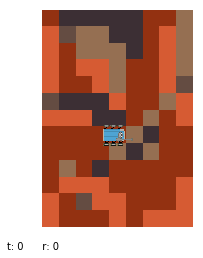

[0.68749304 0.69960075 0.71527159 0.69707006 0.70129462]
2
[0.00000103 0.00041848 0.99849131 0.00011918 0.00097   ]
(4, 7) b'S'
(4, 8) b'1'


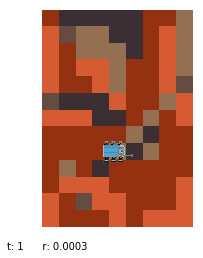

[0.68458731 0.68551154 0.70808344 0.70052395 0.69890145]
2
[0.00000834 0.00001319 0.96712475 0.02270499 0.01014873]
(4, 8) b'1'
(4, 9) b'S'


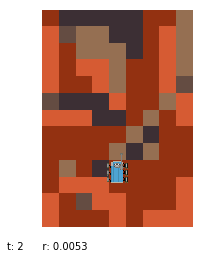

[0.67073151 0.62000524 0.68633742 0.6961905  0.68252911]
3
[0.00000323 0.         0.00745659 0.99141376 0.00112642]
(4, 9) b'S'
(4, 8) b'1'


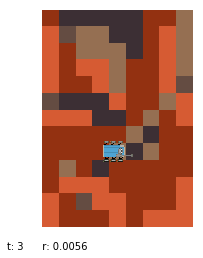

[0.68458731 0.68551154 0.70808344 0.70052395 0.69890145]
2
[0.00000834 0.00001319 0.96712475 0.02270499 0.01014873]
(4, 8) b'1'
(5, 8) b'2'


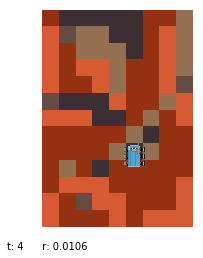

[0.70060715 0.69770796 0.71538615 0.7174353  0.71212634]
3
[0.0001646  0.00003904 0.25227187 0.69749183 0.05003266]
(5, 8) b'2'
(5, 7) b'1'


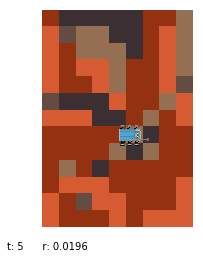

[0.70514868 0.71309059 0.73019348 0.72659229 0.71975955]
2
[0.00000341 0.0001755  0.8523207  0.14269542 0.00480497]
(5, 7) b'1'
(6, 7) b'2'


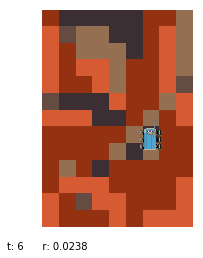

[0.72188093 0.71726082 0.71715094 0.73804683 0.73260062]
3
[0.00030711 0.00003101 0.00002936 0.93685482 0.06277769]
(6, 7) b'2'
(6, 6) b'1'


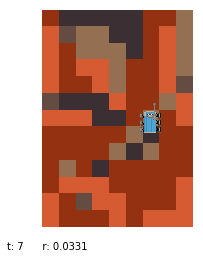

[0.7325591  0.73098787 0.72541252 0.7536775  0.74335771]
3
[0.0000279  0.00001279 0.0000008  0.99402805 0.00593045]
(6, 6) b'1'
(5, 6) b'F'


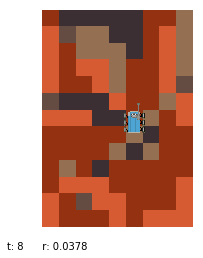

[0.70345308 0.71971722 0.74154878 0.74300281 0.72900346]
3
[0.         0.00000644 0.32682067 0.67252677 0.00064612]
(5, 6) b'F'
(5, 5) b'F'


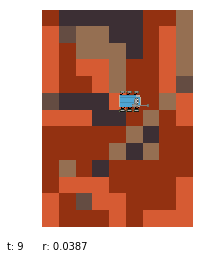

[0.16039685 0.66008766 0.76285799 0.72638495 0.74886654]
2
[0.         0.         0.99903641 0.00000001 0.00096358]
(5, 5) b'F'
(6, 5) b'S'


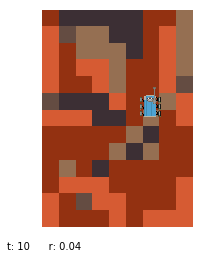

[0.75269909 0.73682334 0.69160999 0.77629787 0.76096267]
3
[0.00000819 0.         0.         0.99949698 0.00049483]
(6, 5) b'S'
(5, 5) b'F'


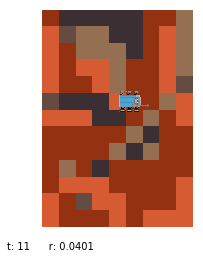

[0.16039685 0.66008766 0.76285799 0.72638495 0.74886654]
2
[0.         0.         0.99903641 0.00000001 0.00096358]
(5, 5) b'F'
(6, 5) b'S'


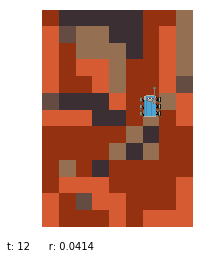

[0.75269909 0.73682334 0.69160999 0.77629787 0.76096267]
3
[0.00000819 0.         0.         0.99949698 0.00049483]
(6, 5) b'S'
(6, 4) b'F'


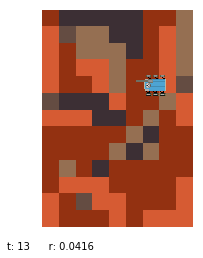

[0.80793876 0.69074627 0.16474769 0.74071557 0.79270088]
0
[0.99948069 0.         0.         0.         0.00051931]
(6, 4) b'F'
(5, 4) b'F'


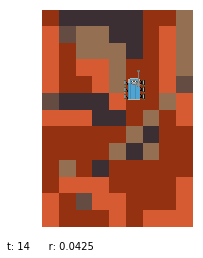

[0.74369339 0.75141895 0.7934091  0.82721964 0.81187508]
3
[0.         0.         0.00000005 0.99950741 0.00049254]
(5, 4) b'F'
(5, 3) b'S'


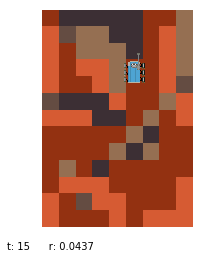

[0.82672453 0.81416086 0.82691703 0.86058148 0.84361741]
3
[0.00000005 0.         0.00000006 0.99977935 0.00022055]
(5, 3) b'S'
(5, 2) b'2'


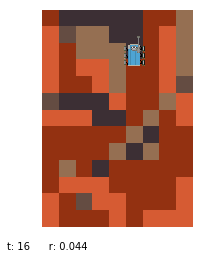

[0.87735972 0.8477719  0.85092083 0.87901118 0.86990085]
3
[0.30355407 0.00000013 0.00000061 0.68895379 0.00749141]
(5, 2) b'2'
(5, 1) b'2'


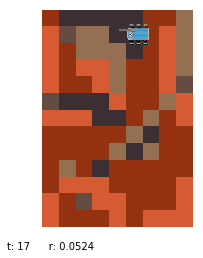

[0.89155641 0.87130971 0.85963832 0.87179818 0.88266652]
0
[0.98791852 0.00004273 0.00000013 0.00005446 0.01198416]
(5, 1) b'2'
(4, 1) b'2'


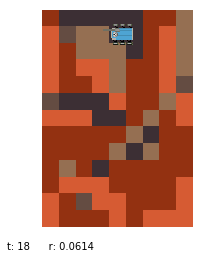

[0.90658489 0.88418896 0.88319025 0.89118258 0.89689398]
0
[0.99141991 0.00001476 0.00000899 0.00047475 0.00808158]
(4, 1) b'2'
(4, 0) b'2'


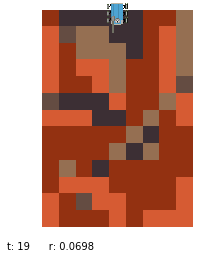

[0.83147277 0.89719067 0.78688717 0.18598448 0.88965618]
1
[0.         0.97678196 0.         0.         0.02321804]
(4, 0) b'2'
(4, 1) b'2'


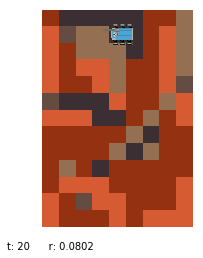

[0.90658489 0.88418896 0.88319025 0.89118258 0.89689398]
0
[0.99141991 0.00001476 0.00000899 0.00047475 0.00808158]
(4, 1) b'2'
(3, 1) b'1'


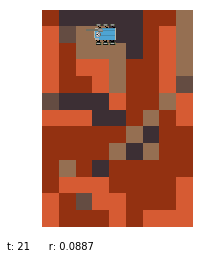

[0.92516635 0.89902408 0.89969723 0.92355718 0.91190982]
0
[0.68901781 0.0000016  0.00000223 0.3100213  0.00095706]
(3, 1) b'1'
(2, 1) b'1'


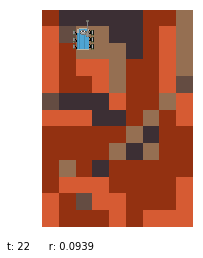

[0.92259708 0.90850685 0.91497178 0.94171485 0.92873038]
3
[0.00007562 0.00000007 0.00000172 0.99833541 0.00158718]
(2, 1) b'1'
(3, 1) b'1'


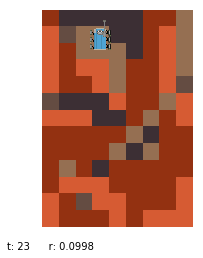

[0.92516635 0.89902408 0.89969723 0.92355718 0.91190982]
3
[0.68901781 0.0000016  0.00000223 0.3100213  0.00095706]
(3, 1) b'1'
(4, 1) b'2'


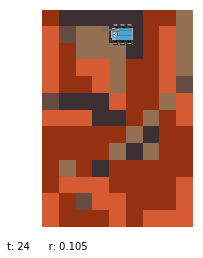

[0.90658489 0.88418896 0.88319025 0.89118258 0.89689398]
0
[0.99141991 0.00001476 0.00000899 0.00047475 0.00808158]
(4, 1) b'2'
(3, 1) b'1'


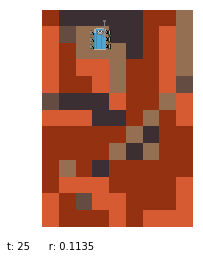

[0.92516635 0.89902408 0.89969723 0.92355718 0.91190982]
3
[0.68901781 0.0000016  0.00000223 0.3100213  0.00095706]
(3, 1) b'1'
(3, 0) b'2'


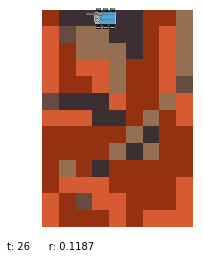

[0.93434633 0.91329094 0.88769155 0.86196806 0.92624343]
0
[0.9823605  0.00002845 0.         0.         0.01761105]
(3, 0) b'2'
(2, 0) b'2'


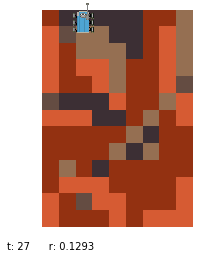

[0.93773101 0.92920202 0.92997883 0.95510606 0.94797466]
3
[0.00017478 0.00000254 0.00000373 0.9716091  0.02820985]
(2, 0) b'2'
(2, 12) b'F'


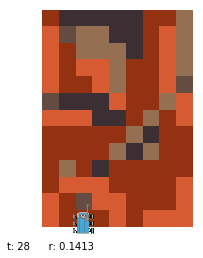

[0.94154    0.93649816 0.87300244 0.97811844 0.96111044]
3
[0.00000001 0.         0.         0.9997842  0.00021579]
(2, 12) b'F'
(2, 11) b'3'


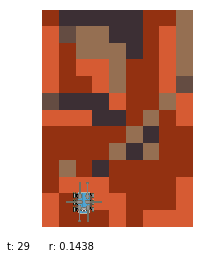

[0.79942962 0.85749322 0.10320866 0.09491387 1.        ]
4
[0. 0. 0. 0. 1.]
(2, 11) b'3'
(2, 11) b'3'


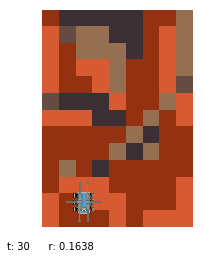

[0.79942962 0.85749322 0.10320866 0.09491387 1.        ]
4
[0. 0. 0. 0. 1.]
(2, 11) b'3'
(2, 11) b'3'


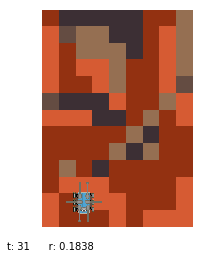

[0.79942962 0.85749322 0.10320866 0.09491387 1.        ]
4
[0. 0. 0. 0. 1.]
(2, 11) b'3'
(2, 11) b'3'


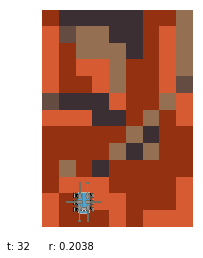

[0.79942962 0.85749322 0.10320866 0.09491387 1.        ]
4
[0. 0. 0. 0. 1.]
(2, 11) b'3'
(2, 11) b'3'


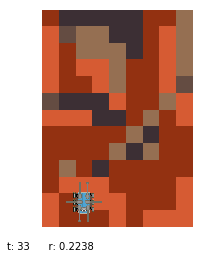

[0.79942962 0.85749322 0.10320866 0.09491387 1.        ]
4
[0. 0. 0. 0. 1.]
(2, 11) b'3'
(2, 11) b'3'


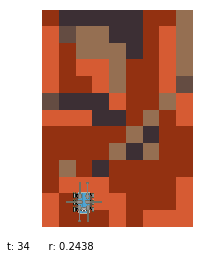

[0.79942962 0.85749322 0.10320866 0.09491387 1.        ]
4
[0. 0. 0. 0. 1.]
(2, 11) b'3'
(2, 11) b'3'


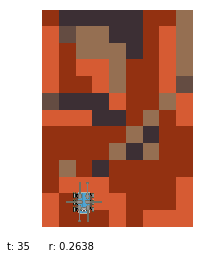

[0.79942962 0.85749322 0.10320866 0.09491387 1.        ]
4
[0. 0. 0. 0. 1.]
(2, 11) b'3'
(2, 11) b'3'


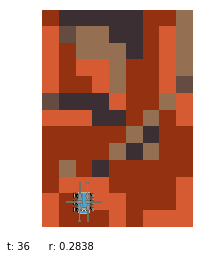

[0.79942962 0.85749322 0.10320866 0.09491387 1.        ]
4
[0. 0. 0. 0. 1.]
(2, 11) b'3'
(2, 11) b'3'


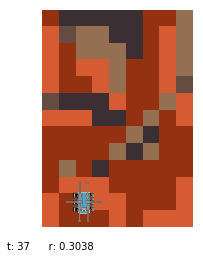

[0.79942962 0.85749322 0.10320866 0.09491387 1.        ]
4
[0. 0. 0. 0. 1.]
(2, 11) b'3'
(2, 11) b'3'


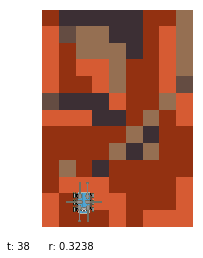

[0.79942962 0.85749322 0.10320866 0.09491387 1.        ]
4
[0. 0. 0. 0. 1.]
(2, 11) b'3'
(2, 11) b'3'


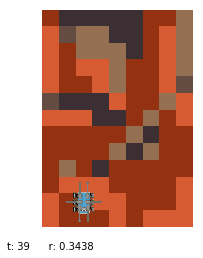

[0.79942962 0.85749322 0.10320866 0.09491387 1.        ]
4
[0. 0. 0. 0. 1.]
(2, 11) b'3'
(2, 11) b'3'


In [16]:
Q = tabsoftq_learn_Qs(mdp)
plot_mars(mdp,tabsoftq_gen_pol(Q, temperature),Qs=Q)


In [17]:
print(mdp.feature_map)

[[0.67521987 0.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         1.         0.        ]
 [0.87991869 0.         0.         0.        ]
 [0.6929929  0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         1.        ]
 [0.         1.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         1.         0.        ]
 [0.64280487 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.66991448 0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         

# Inverse Dynamics Learning

In [18]:
def transition_grad(adt, tps):
    a,d,t = adt
    grad_theta_t = np.zeros(tps.shape)
    grad_theta_t[a,d,t] += 1
    grad_theta_t[a,:,t] -= tps[a,:,t]
    return grad_theta_t


In [19]:
def tabsoftq_T_grad_iter(T_thetas, Q, R, T=None, maxiter=1000, verbose=True,
                       learning_rate=1, G_init=None, ftol=0):
    
    T_theta_dim = T_thetas.shape[0] * T_thetas.shape[1] * T_thetas.shape[2]
    D = T_thetas.shape[1]
    
    P_broad = tabsoftq_gen_pol_probs(Q,temperature).reshape((nS, nA, 1))
    Tps = softmax(T_thetas,axis=1)
    
    if T is None:
        T = mdp.adt_trans_to_sas_trans(Tps)
        
    V = (alpha / temperature) * logsumexp(Q * (temperature / alpha), axis=1)
    T_grad = np.zeros((nS,nA,T_theta_dim))
    for s in range(nS):
        t = mdp.get_tile_type(s)
        for a in range(nA):
            P_at = Tps[a,:,t]
            V_theta = np.array([V[mdp.sd_to_sprime(s,d)] for d in range(D)])
            R_theta = np.array([R[mdp.sd_to_sprime(s,d)] for d in range(D)])
            VR_theta = R_theta + gamma * V_theta 
            D_probs = np.stack([P_at for _ in range(D)])
            grad_at = np.dot((np.eye(D) - D_probs), VR_theta)
            grad_at = np.dot(np.diag(P_at),grad_at)
            filler = np.zeros(T_thetas.shape)
            filler[a,:,t] = grad_at
            filler = filler.flatten()
            T_grad[s,a] = filler
    G = T_grad if G_init is None else G_init
    T_broad = T.reshape((nS, nA, nS, 1))
    prevG = copy(G)
    if verbose:
        diffs = []
    for iter_idx in range(maxiter):
        expG = np.sum(P_broad * G, axis=1)
        expG_broad = expG.reshape((1, 1, nS, T_theta_dim))
        G = gamma * T_grad
        t_expG = np.sum(T_broad * expG_broad, axis=2)
        G += gamma * t_expG
        G = (1 - learning_rate) * prevG + learning_rate * G
    
        diff = np.mean((G - prevG)**2)/(np.std(G)**2)
        if verbose:
            diffs.append(diff)
        if diff < ftol:
            break
        prevG = copy(G)
  
    if verbose:
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Squared Bellman Error')
        plt.title('Soft Q Gradient Iteration')
        plt.plot(diffs)
        plt.yscale('log')
        plt.show()
    expG = np.sum(P_broad * G, axis=1)
    expG_broad = expG.reshape((nS, 1, T_theta_dim))
    return (G - expG_broad) * temperature

In [20]:
def eval_pol_likelihood(Q, sas_obs, verbose=False):
    ll = 0.0
    for obs in sas_obs:
        s,a,sprime = obs
        l = np.log(softmax(Q[s] * temperature)[a])
        ll += l
    return ll

def eval_trans_likelihood(Tps, adt_obs, verbose=False):
    ll = 0.0
    for obs in adt_obs:
        a,d,t, = obs
        l = np.log(Tps[a,d,t])
        ll += l
    return ll

def eval_trans_likelihood_and_grad(T_thetas, adt_obs):
    Tps = softmax(T_thetas,axis=1)
    dT = sum([transition_grad(adt,Tps) for adt in adt_obs]).reshape(T_thetas.shape) / len(adt_obs)
    ll = eval_trans_likelihood(Tps, adt_obs)
    return ll, dT

def eval_demo_log_likelihood(sas_obs, adt_obs, T_thetas, Q):
    Tps = softmax(T_thetas,axis=1)
    p_ll = eval_pol_likelihood(Q, sas_obs)
    t_ll = eval_trans_likelihood(Tps, adt_obs)
    return p_ll, t_ll
        

In [21]:
def eval_T_pol_likelihood_and_grad(T_thetas, R, sas_obs, Q_inits=None, verbose=False):
    s = [obs[0] for obs in sas_obs]
    a = [obs[1] for obs in sas_obs]
    Tps = softmax(T_thetas,axis=1)
    T = mdp.adt_trans_to_sas_trans(Tps)
    Q = tabsoftq_iter(R, T, Q_init=Q_inits if Q_inits is not None else None, 
        maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)
    dT = tabsoftq_T_grad_iter(T_thetas, Q, R, T=T, maxiter=tabsoftq_grad_iter_maxiter,
        verbose=tabsoftq_grad_iter_verbose, ftol=tabsoftq_grad_iter_ftol)
    # Sum instead of mean because sparse results
    if verbose:
        for obs in sas_obs:
            print(obs)
            print(dT[obs[0],obs[1]].reshape(T_thetas.shape))
    dT = np.sum(dT[s,a], axis=0).reshape(T_thetas.shape) / len(sas_obs)
    ll = eval_pol_likelihood(Q, sas_obs)
    return ll, dT, Q


# Simultaneous Estimation of Rewards and Dynamics

In [22]:
def tabsoftq_TR_grad_iter(T_thetas, R_thetas, feat_mat, Q, T=None, maxiter=1000, verbose=True,
                       learning_rate=1, G_init=None, ftol=0):
    
    T_theta_dim = T_thetas.shape[0] * T_thetas.shape[1] * T_thetas.shape[2]
    D = T_thetas.shape[1]
    
    R_theta_dim = R_thetas.shape[0]
    
    P_broad = tabsoftq_gen_pol_probs(Q,temperature).reshape((nS, nA, 1))
    Tps = softmax(T_thetas,axis=1)
    
    if T is None:
        T = mdp.adt_trans_to_sas_trans(Tps)
        
    V = (alpha / temperature) * logsumexp(Q * (temperature / alpha), axis=1)
    
    R_grad = T.dot(feat_mat)
    R = feat_mat.dot(R_thetas)
    
    GR = np.zeros((nS, nA, R_theta_dim)) if G_init is None else G_init[0]
    prevGR = copy(GR)
    
    T_grad = np.zeros((nS,nA,T_theta_dim))
    for s in range(nS):
        t = mdp.get_tile_type(s)
        for a in range(nA):
            P_at = Tps[a,:,t]
            V_theta = np.array([V[mdp.sd_to_sprime(s,d)] for d in range(D)])
            R_theta = np.array([R[mdp.sd_to_sprime(s,d)] for d in range(D)])
            VR_theta = R_theta + gamma * V_theta 
            D_probs = np.stack([P_at for _ in range(D)])
            grad_at = np.dot((np.eye(D) - D_probs), VR_theta)
            grad_at = np.dot(np.diag(P_at),grad_at)
            filler = np.zeros(T_thetas.shape)
            filler[a,:,t] = grad_at
            filler = filler.flatten()
            T_grad[s,a] = filler
              
    GT = T_grad if G_init is None else G_init[1]
    T_broad = T.reshape((nS, nA, nS, 1))
    prevGT = copy(GT)
    
    if verbose:
        diffs = []
        
    for iter_idx in range(maxiter):
        # Reward Param gradient iteration
        expGR = np.sum(P_broad * GR, axis=1)
        expGR_broad = expGR.reshape((1, 1, nS, R_theta_dim))
        GR = R_grad + gamma * np.sum(T_broad * expGR_broad, axis=2)
        GR = (1 - learning_rate) * prevGR + learning_rate * GR
        
        
        # Transition Param grad iter
        expGT = np.sum(P_broad * GT, axis=1)
        expGT_broad = expGT.reshape((1, 1, nS, T_theta_dim))
        GT = gamma * T_grad
        t_expGT = np.sum(T_broad * expGT_broad, axis=2)
        GT += gamma * t_expGT
        GT = (1 - learning_rate) * prevGT + learning_rate * GT
    
        diff = np.mean((GR - prevGR)**2)/(np.std(GR)**2) + np.mean((GT - prevGT)**2)/(np.std(GT)**2)
        if verbose:
            diffs.append(diff)
        if diff < ftol:
            break
        prevGR = copy(GR)
        prevGT = copy(GT)
  
    if verbose:
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Squared Bellman Error')
        plt.title('Soft Q Gradient Iteration')
        plt.plot(diffs)
        plt.yscale('log')
        plt.show()
  
    expGR = np.sum(P_broad * GR, axis=1)
    expGR_broad = expGR.reshape((nS, 1, R_theta_dim))
    expGT = np.sum(P_broad * GT, axis=1)
    expGT_broad = expGT.reshape((nS, 1, T_theta_dim))
    return (GR - expGR_broad) * temperature, (GT - expGT_broad) * temperature

In [23]:
def eval_TR_pol_likelihood_and_grad(T_thetas, R_thetas, feat_map, sas_obs, Q_inits=None, verbose=False):
    s = [obs[0] for obs in sas_obs]
    a = [obs[1] for obs in sas_obs]
    Tps = softmax(T_thetas,axis=1)
    T = mdp.adt_trans_to_sas_trans(Tps)
    R = feat_map.dot(R_thetas) * reward_normalizer
    Q = tabsoftq_iter(R, T, Q_init=Q_inits if Q_inits is not None else None, 
        maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)
    dR, dT = tabsoftq_TR_grad_iter(T_thetas, R_thetas, feat_map, Q, T=T, maxiter=tabsoftq_grad_iter_maxiter,
        verbose=tabsoftq_grad_iter_verbose, ftol=tabsoftq_grad_iter_ftol)
    if verbose:
        for obs in sas_obs:
            print(obs)
            print(dT[obs[0],obs[1]].reshape(T_thetas.shape))
    dR = np.sum(dR[s,a], axis=0).reshape(R_thetas.shape) / len(sas_obs)
    dT = np.sum(dT[s,a], axis=0).reshape(T_thetas.shape) / len(sas_obs)
    ll = eval_pol_likelihood(Q, sas_obs)
    return ll, dT, dR, Q

# IDL & SERD Experiments

In [29]:
tabsoftq_iter_ftol = 1e-32
tabsoftq_iter_maxiter = 5000
tabsoftq_iter_verbose = False
tabsoftq_grad_iter_ftol = 1e-10
tabsoftq_grad_iter_maxiter = 5000
tabsoftq_grad_iter_verbose = False
learning_rate = 3e-1
batch_size = 200
maxiter = 400
n_demos = 80
demo_time_steps = 40

In [30]:
def clean_demos(sas_obs):
    demo_example_idxes = list(range(len(sas_obs)))
    unique_stays = set([])
    for i,sas in enumerate(sas_obs):
        sas = tuple(sas)
        if sas[1] == 4:
            if sas in unique_stays:
                demo_example_idxes.remove(i)
            else:
                unique_stays.add(sas)
    return demo_example_idxes

def sample_batch(size, ids, sas_obs, adt_obs):
    idxes = random.sample(ids, size)
    return sas_obs[idxes], adt_obs[idxes]

In [31]:
def T_estimate(adt_obs):
    stability = 1e-5
    T_thetas = np.zeros(T_theta_shape)
    T_counts = np.zeros(T_theta_shape) + stability
    for a,d,t in adt_obs:
        T_counts[a,d,t] += 1
    for a in range(T_theta_shape[0]):
        for t in range(T_theta_shape[2]):
            z = np.sum(T_counts[a,:,t])
            for d in range(T_theta_shape[1]):
                if z == T_counts.shape[1] * stability:
                    T_thetas[a,d,t] = 0
                else:
                    T_thetas[a,d,t] = np.log(T_counts[a,d,t]) - np.log(z)
    return T_thetas

def test_T_likelihood(Tps, sas_obs, adt_obs):
    T = mdp.adt_trans_to_sas_trans(Tps)
    R = mdp.rewards
    Q = tabsoftq_iter(R, T, Q_init=None, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)
    pl = eval_pol_likelihood(Q, sas_obs, verbose=True)
    tl = eval_trans_likelihood(Tps, adt_obs, verbose=True)
    print([s for s in range(nS) if mdp.get_tile_type(s)==1])
    print(Q[[s for s in range(nS) if mdp.get_tile_type(s)==1]])
    print(pl, tl)
    return pl + tl

def true_trans_loss(tps):
    tps = mdp.adt_trans_to_sas_trans(tps)
    true_tps = mdp.get_transition_matrix()
    return np.linalg.norm(true_tps-tps)

In [32]:
exQs = tabsoftq_learn_Qs(mdp)
demos = generate_demonstrations(mdp, tabsoftq_gen_pol(exQs,temperature), n_demos, demo_time_steps)
sas_obs, adt_obs = vectorize_rollouts(demos)

In [33]:
# Ensure bad areas have not been visited in exes
while len(set([adt[2] for adt in adt_obs])) > 1:
    demos = generate_demonstrations(mdp, tabsoftq_gen_pol(exQs,temperature), n_demos, demo_time_steps)
    sas_obs, adt_obs = vectorize_rollouts(demos)

In [34]:
# Clean training set to have greater density of interesting transitions
# print(len(sas_obs))
# demo_example_idxes = clean_demos(sas_obs)
# print(len(demo_example_idxes))
demo_example_idxes = list(range(len(sas_obs)))


In [35]:
random.shuffle(demo_example_idxes)
n_train_demo_examples = int(0.9 * len(demo_example_idxes))
train_demo_example_idxes = demo_example_idxes[:n_train_demo_examples]
val_demo_example_idxes = demo_example_idxes[n_train_demo_examples:]
val_sas_obs = sas_obs[val_demo_example_idxes]
val_adt_obs = adt_obs[val_demo_example_idxes]

## IDL Only

In [36]:
idl_train_logs = {
  'train_likelihoods': [],
  'val_likelihoods': [],
  'tp_lls': [],
  'tt_lls': [],
  'vp_lls': [],
  'vt_lls': []
}

In [37]:
Ti_thetas = T_estimate(adt_obs[train_demo_example_idxes])
Qi, Ri = None, mdp.rewards

In [38]:
while len(idl_train_logs['tt_lls']) < maxiter:
    batch_demo_sas, batch_demo_adt = sample_batch(batch_size, train_demo_example_idxes, sas_obs, adt_obs)
    #Should we initialize Qs or nah?
    tp_ll, dT_pol, Qi = eval_T_pol_likelihood_and_grad(Ti_thetas, Ri, batch_demo_sas, Q_inits=Qi)
    tt_ll, dT_trans = eval_trans_likelihood_and_grad(Ti_thetas, batch_demo_adt)
    train_likelihood = tp_ll + tt_ll
    vp_ll, vt_ll = eval_demo_log_likelihood(val_sas_obs, val_adt_obs, Ti_thetas, Qi)
    val_likelihood = vp_ll + vt_ll
    Ti_thetas += learning_rate * (dT_trans + dT_pol)
    
    print('%d %f %f' % (len(idl_train_logs['tt_lls']), vp_ll, vt_ll))
    idl_train_logs['train_likelihoods'].append(train_likelihood)
    idl_train_logs['val_likelihoods'].append(val_likelihood)
    idl_train_logs['tp_lls'].append(tp_ll)
    idl_train_logs['tt_lls'].append(tt_ll)
    idl_train_logs['vp_lls'].append(vp_ll)
    idl_train_logs['vt_lls'].append(vt_ll)

0 -411.835997 -95.395428
1 -383.214157 -94.633907
2 -368.476306 -94.464979
3 -337.423192 -94.187425
4 -318.493023 -94.200371
5 -287.656952 -94.352590
6 -274.829027 -94.364737
7 -266.761033 -94.479007
8 -255.398522 -94.596913
9 -248.621504 -94.618838
10 -235.011974 -94.907720
11 -225.839044 -95.307562
12 -215.133876 -95.454243
13 -207.352644 -95.718902
14 -202.894363 -95.943652
15 -199.506030 -96.065820
16 -195.208812 -96.325790
17 -191.040790 -96.651595
18 -186.538401 -96.892919
19 -180.347857 -97.381090
20 -176.394029 -97.862920
21 -171.781058 -98.101566
22 -167.223020 -98.554005
23 -160.977767 -99.179736
24 -158.377516 -99.144384
25 -153.424709 -99.897655
26 -149.765786 -100.458874
27 -147.237205 -100.656767
28 -144.466517 -100.999004
29 -141.729996 -101.299652
30 -142.410366 -101.016143
31 -140.731253 -101.110146
32 -138.609748 -101.289634
33 -132.160346 -102.438780
34 -128.967160 -103.081186
35 -126.211662 -103.594997
36 -125.826175 -103.284909
37 -124.543952 -103.584543
38 -122.50

307 -52.658321 -111.801208
308 -52.877890 -111.622659
309 -52.260428 -112.058082
310 -52.667853 -111.900575
311 -52.758605 -112.084900
312 -52.664788 -111.662111
313 -52.505778 -111.891133
314 -52.485702 -111.843650
315 -52.401865 -111.881930
316 -52.120213 -111.954323
317 -52.152383 -111.464812
318 -51.885369 -111.649131
319 -52.302504 -111.294984
320 -52.363618 -111.134901
321 -51.615348 -111.832862
322 -51.956548 -111.358018
323 -51.825159 -111.632594
324 -51.490183 -111.462817
325 -51.166276 -111.414352
326 -50.733573 -112.051236
327 -50.549015 -112.108971
328 -50.199549 -112.526922
329 -50.465378 -111.580319
330 -50.154882 -111.875770
331 -50.181192 -112.193937
332 -50.054951 -112.410207
333 -50.174999 -112.009017
334 -49.781201 -112.490923
335 -49.992213 -112.815771
336 -50.044822 -112.462273
337 -49.853237 -112.852623
338 -50.119352 -112.292887
339 -50.372222 -111.869020
340 -50.270515 -111.917874
341 -49.525026 -112.509202
342 -49.610977 -112.259576
343 -49.822002 -111.755936
3

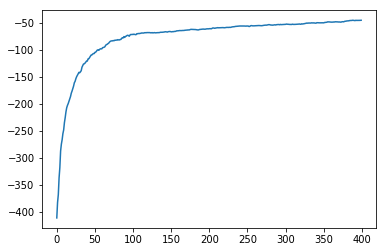

In [39]:
plt.plot(idl_train_logs['vp_lls'])

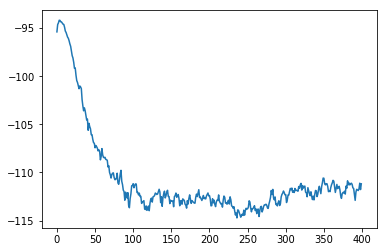

In [40]:
plt.plot(idl_train_logs['vt_lls'])

In [41]:
print(Qi[[s for s in range(nS) if mdp.get_tile_type(s)==1]])

[[0.78587574 0.78587574 0.78587574 0.78587574 0.78587574]
 [0.75895232 0.75895232 0.75895232 0.75895232 0.75895232]
 [0.7605336  0.7605336  0.7605336  0.7605336  0.7605336 ]
 [0.74206929 0.74206929 0.74206929 0.74206929 0.74206929]
 [0.73636909 0.73636909 0.73636909 0.73636909 0.73636909]
 [0.78816818 0.78816818 0.78816818 0.78816818 0.78816818]
 [0.78653087 0.78653087 0.78653087 0.78653087 0.78653087]
 [0.73086662 0.73086662 0.73086662 0.73086662 0.73086662]
 [0.7446978  0.7446978  0.7446978  0.7446978  0.7446978 ]
 [0.75248818 0.75248818 0.75248818 0.75248818 0.75248818]
 [0.74696007 0.74696007 0.74696007 0.74696007 0.74696007]
 [0.7441507  0.7441507  0.7441507  0.7441507  0.7441507 ]
 [0.72383074 0.72383074 0.72383074 0.72383074 0.72383074]
 [0.66607262 0.66607262 0.66607262 0.66607262 0.66607262]
 [0.668935   0.668935   0.668935   0.668935   0.668935  ]
 [0.68701861 0.68701861 0.68701861 0.68701861 0.68701861]
 [0.6788334  0.6788334  0.6788334  0.6788334  0.6788334 ]
 [0.69099156 0

/Users/mckaneandrus/anaconda2/envs/irld/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


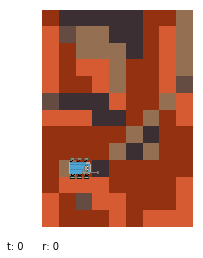

(2, 9) b'S'
(2, 10) b'U'


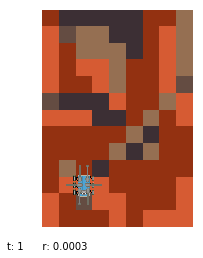

(2, 10) b'U'
(2, 10) b'U'


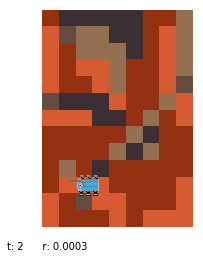

(2, 10) b'U'
(2, 10) b'U'


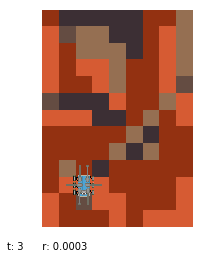

(2, 10) b'U'
(2, 10) b'U'


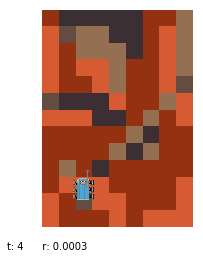

(2, 10) b'U'
(2, 10) b'U'


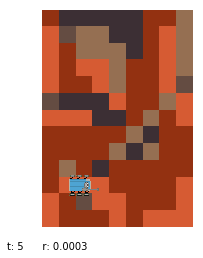

(2, 10) b'U'
(2, 10) b'U'


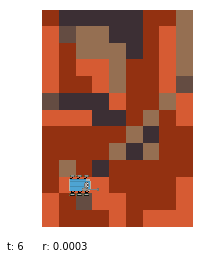

(2, 10) b'U'
(2, 10) b'U'


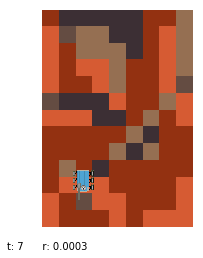

(2, 10) b'U'
(2, 10) b'U'


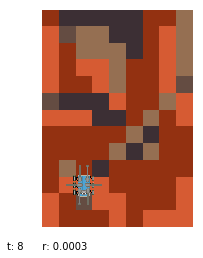

(2, 10) b'U'
(2, 10) b'U'


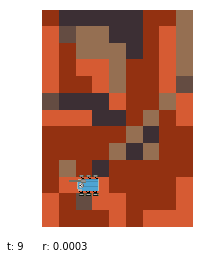

(2, 10) b'U'
(2, 10) b'U'


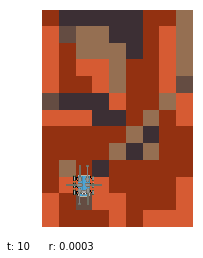

(2, 10) b'U'
(2, 10) b'U'


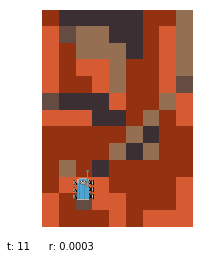

(2, 10) b'U'
(2, 10) b'U'


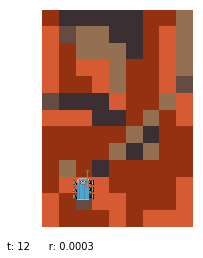

(2, 10) b'U'
(2, 10) b'U'


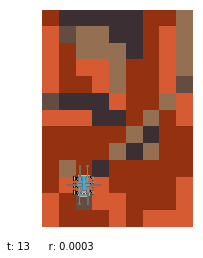

(2, 10) b'U'
(2, 10) b'U'


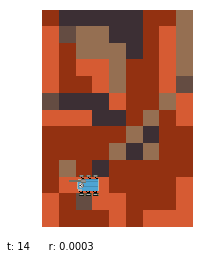

(2, 10) b'U'
(2, 10) b'U'


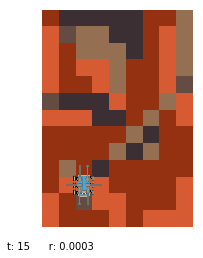

(2, 10) b'U'
(2, 10) b'U'


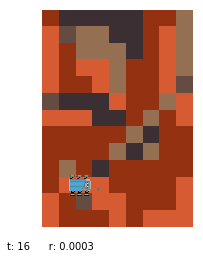

(2, 10) b'U'
(2, 10) b'U'


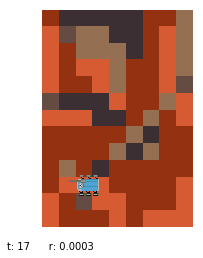

(2, 10) b'U'
(2, 10) b'U'


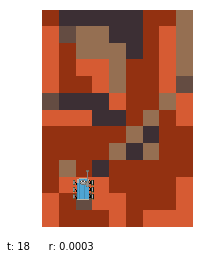

(2, 10) b'U'
(2, 10) b'U'


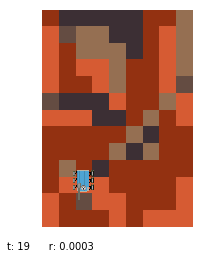

(2, 10) b'U'
(2, 10) b'U'


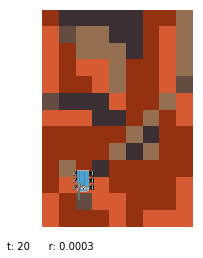

(2, 10) b'U'
(2, 10) b'U'


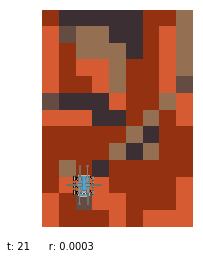

(2, 10) b'U'
(2, 10) b'U'


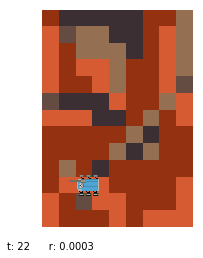

(2, 10) b'U'
(2, 10) b'U'


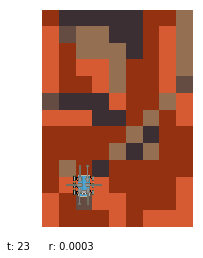

(2, 10) b'U'
(2, 10) b'U'


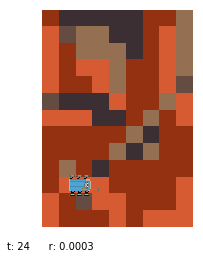

(2, 10) b'U'
(2, 10) b'U'


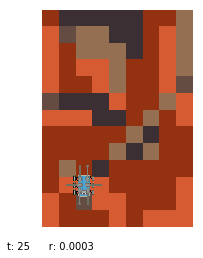

(2, 10) b'U'
(2, 10) b'U'


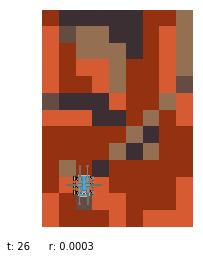

(2, 10) b'U'
(2, 10) b'U'


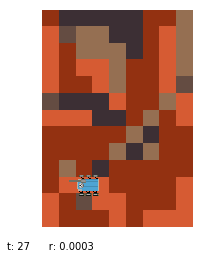

(2, 10) b'U'
(2, 10) b'U'


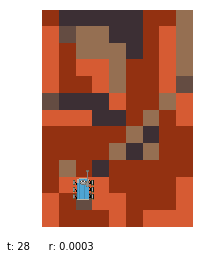

(2, 10) b'U'
(2, 10) b'U'


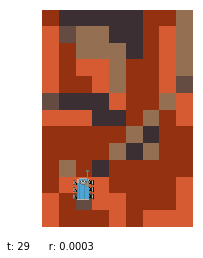

(2, 10) b'U'
(2, 10) b'U'


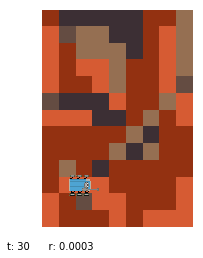

(2, 10) b'U'
(2, 10) b'U'


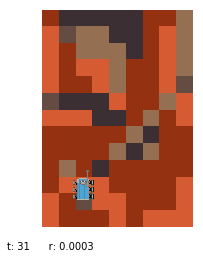

(2, 10) b'U'
(2, 10) b'U'


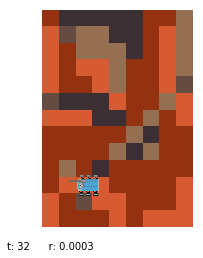

(2, 10) b'U'
(2, 10) b'U'


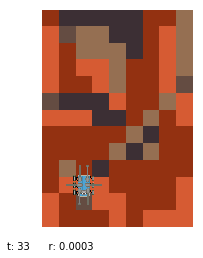

(2, 10) b'U'
(2, 10) b'U'


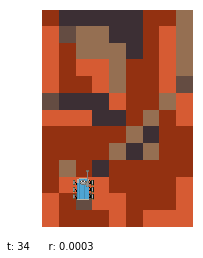

(2, 10) b'U'
(2, 10) b'U'


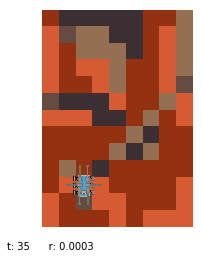

(2, 10) b'U'
(2, 10) b'U'


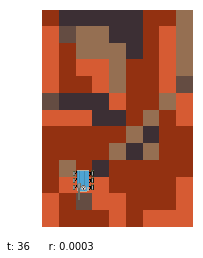

(2, 10) b'U'
(2, 10) b'U'


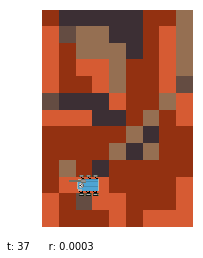

(2, 10) b'U'
(2, 10) b'U'


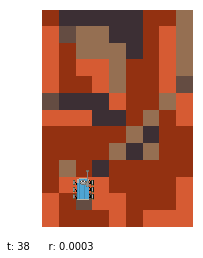

(2, 10) b'U'
(2, 10) b'U'


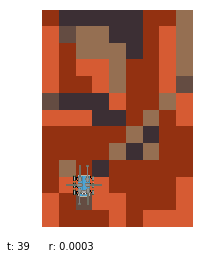

(2, 10) b'U'
(2, 10) b'U'
[[[0.77917661 0.11249422]
  [0.04931367 0.08831134]
  [0.00000002 0.11682622]
  [0.17150968 0.1015057 ]
  [0.00000002 0.58086251]]

 [[0.5450258  0.11249422]
  [0.16584808 0.08831134]
  [0.28912545 0.11682622]
  [0.00000034 0.1015057 ]
  [0.00000034 0.58086251]]

 [[0.00000005 0.11249422]
  [0.03290858 0.08831134]
  [0.53053238 0.11682622]
  [0.43655894 0.1015057 ]
  [0.00000005 0.58086251]]

 [[0.19329021 0.11249422]
  [0.00000001 0.08831134]
  [0.11455897 0.11682622]
  [0.69215079 0.1015057 ]
  [0.00000001 0.58086251]]

 [[0.00000001 0.11249422]
  [0.00000001 0.08831134]
  [0.00000001 0.11682622]
  [0.00000001 0.1015057 ]
  [0.99999997 0.58086251]]]


In [42]:
plot_mars(mdp,tabsoftq_gen_pol(Qi, temperature))
print(softmax(Ti_thetas))

In [43]:
tabsoftq_gen_pol_probs(Qi, temperature)[:,4]

array([0.00057281, 0.02686876, 0.03236178, 0.01953329, 0.02257524,
       0.02997493, 0.00058603, 0.0007315 , 0.00673329, 0.2       ,
       0.30215604, 0.00193508, 0.0012442 , 0.00885236, 0.0135252 ,
       0.00037597, 0.2       , 0.00435775, 0.2       , 0.00028223,
       0.00191365, 0.00214264, 0.00128709, 0.00692272, 0.00037839,
       0.2       , 0.00311943, 0.2       , 0.00042858, 0.2       ,
       0.2       , 0.00103212, 0.00024928, 0.00048208, 0.2       ,
       0.0028246 , 0.2       , 0.00074732, 0.00094991, 0.2       ,
       0.00293087, 0.00052155, 0.00038282, 0.2       , 1.        ,
       0.50270478, 0.04314264, 0.05404286, 0.06059125, 0.2       ,
       0.00064431, 0.0004578 , 0.00513361, 0.2       , 0.2       ,
       0.2       , 0.2       , 0.02624252, 0.02995828, 0.0006674 ,
       0.00553244, 0.00119126, 0.2       , 0.00236642, 0.00103794,
       0.00120298, 0.00150535, 0.00067907, 0.00292001, 0.0595092 ,
       0.00069584, 0.00157646, 0.00214312, 0.00076101, 0.00209

In [44]:
print(softmax(Ti_thetas)) # - softmax(T_estimate(adt_obs[train_demo_example_idxes])))

[[[0.77917661 0.11249422]
  [0.04931367 0.08831134]
  [0.00000002 0.11682622]
  [0.17150968 0.1015057 ]
  [0.00000002 0.58086251]]

 [[0.5450258  0.11249422]
  [0.16584808 0.08831134]
  [0.28912545 0.11682622]
  [0.00000034 0.1015057 ]
  [0.00000034 0.58086251]]

 [[0.00000005 0.11249422]
  [0.03290858 0.08831134]
  [0.53053238 0.11682622]
  [0.43655894 0.1015057 ]
  [0.00000005 0.58086251]]

 [[0.19329021 0.11249422]
  [0.00000001 0.08831134]
  [0.11455897 0.11682622]
  [0.69215079 0.1015057 ]
  [0.00000001 0.58086251]]

 [[0.00000001 0.11249422]
  [0.00000001 0.08831134]
  [0.00000001 0.11682622]
  [0.00000001 0.1015057 ]
  [0.99999997 0.58086251]]]


In [45]:
Tps2 = np.array([[[0.8, 0.],
  [0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.0, 1.]],

 [[0.1, 0.],
  [0.8, 0.],
  [0.1, 0.],
  [0.0, 0.],
  [0.0, 1.]],

 [[0.0, 0.],
  [0.1, 0.],
  [0.8, 0.],
  [0.1, 0.],
  [0.0, 1.]],

 [[0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.8, 0.],
  [0.0, 1.]],

 [[0., 0.],
  [0., 0.],
  [0., 0.],
  [0., 0.],
  [1., 1.]]])

In [46]:
test_T_likelihood(softmax(Ti_thetas), val_sas_obs, val_adt_obs)

[9, 16, 18, 25, 27, 29, 30, 34, 36, 39, 43, 49, 53, 54, 55, 56, 62, 91, 92, 93, 98, 99, 102, 103, 107, 108, 112, 114, 115, 116]
[[0.78586367 0.78586367 0.78586367 0.78586367 0.78586367]
 [0.75877819 0.75877819 0.75877819 0.75877819 0.75877819]
 [0.76043232 0.76043232 0.76043232 0.76043232 0.76043232]
 [0.74197153 0.74197153 0.74197153 0.74197153 0.74197153]
 [0.73626408 0.73626408 0.73626408 0.73626408 0.73626408]
 [0.78818724 0.78818724 0.78818724 0.78818724 0.78818724]
 [0.78649673 0.78649673 0.78649673 0.78649673 0.78649673]
 [0.73078544 0.73078544 0.73078544 0.73078544 0.73078544]
 [0.74464998 0.74464998 0.74464998 0.74464998 0.74464998]
 [0.75246572 0.75246572 0.75246572 0.75246572 0.75246572]
 [0.74690153 0.74690153 0.74690153 0.74690153 0.74690153]
 [0.74415567 0.74415567 0.74415567 0.74415567 0.74415567]
 [0.7237852  0.7237852  0.7237852  0.7237852  0.7237852 ]
 [0.6660486  0.6660486  0.6660486  0.6660486  0.6660486 ]
 [0.66889677 0.66889677 0.66889677 0.66889677 0.66889677]
 [

-156.30332216422795

In [47]:
test_T_likelihood(softmax(T_estimate(adt_obs[train_demo_example_idxes])), val_sas_obs, val_adt_obs)

[9, 16, 18, 25, 27, 29, 30, 34, 36, 39, 43, 49, 53, 54, 55, 56, 62, 91, 92, 93, 98, 99, 102, 103, 107, 108, 112, 114, 115, 116]
[[0.88871709 0.88871709 0.88871709 0.88871709 0.88871709]
 [0.85613536 0.85613536 0.85613536 0.85613536 0.85613536]
 [0.8592179  0.8592179  0.8592179  0.8592179  0.8592179 ]
 [0.83700449 0.83700449 0.83700449 0.83700449 0.83700449]
 [0.83687493 0.83687493 0.83687493 0.83687493 0.83687493]
 [0.8658038  0.8658038  0.8658038  0.8658038  0.8658038 ]
 [0.86062036 0.86062036 0.86062036 0.86062036 0.86062036]
 [0.81947787 0.81947787 0.81947787 0.81947787 0.81947787]
 [0.82753589 0.82753589 0.82753589 0.82753589 0.82753589]
 [0.833484   0.833484   0.833484   0.833484   0.833484  ]
 [0.80855401 0.80855401 0.80855401 0.80855401 0.80855401]
 [0.81937208 0.81937208 0.81937208 0.81937208 0.81937208]
 [0.7955294  0.7955294  0.7955294  0.7955294  0.7955294 ]
 [0.77818797 0.77818797 0.77818797 0.77818797 0.77818797]
 [0.7881905  0.7881905  0.7881905  0.7881905  0.7881905 ]
 [

-507.2314249757326

In [48]:
test_T_likelihood(Tps2, val_sas_obs, val_adt_obs)

[9, 16, 18, 25, 27, 29, 30, 34, 36, 39, 43, 49, 53, 54, 55, 56, 62, 91, 92, 93, 98, 99, 102, 103, 107, 108, 112, 114, 115, 116]
[[0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [

-123.55830707561888

In [49]:
true_trans_loss(softmax(Ti_thetas))

10.363323948546372

In [50]:
true_trans_loss(softmax(T_estimate(adt_obs[train_demo_example_idxes])))

10.9642602940769

In [51]:
softmax(T_estimate(adt_obs[train_demo_example_idxes]))

array([[[0.78539817, 0.2       ],
        [0.10840709, 0.2       ],
        [0.00000002, 0.2       ],
        [0.1061947 , 0.2       ],
        [0.00000002, 0.2       ]],

       [[0.09523822, 0.2       ],
        [0.78571359, 0.2       ],
        [0.11904772, 0.2       ],
        [0.00000024, 0.2       ],
        [0.00000024, 0.2       ]],

       [[0.00000005, 0.2       ],
        [0.09547741, 0.2       ],
        [0.82412045, 0.2       ],
        [0.08040204, 0.2       ],
        [0.00000005, 0.2       ]],

       [[0.10543841, 0.2       ],
        [0.00000001, 0.2       ],
        [0.08102109, 0.2       ],
        [0.81354048, 0.2       ],
        [0.00000001, 0.2       ]],

       [[0.00000001, 0.2       ],
        [0.00000001, 0.2       ],
        [0.00000001, 0.2       ],
        [0.00000001, 0.2       ],
        [0.99999997, 0.2       ]]])

## SERD only

In [60]:
serd_train_logs = {
  'train_likelihoods': [],
  'val_likelihoods': [],
  'tp_lls': [],
  'tt_lls': [],
  'vp_lls': [],
  'vt_lls': []
}

In [61]:
Ts_thetas = T_estimate(adt_obs[train_demo_example_idxes]) #np.log(Tps2+.000000001)
feats = mdp.feature_map
Rs_thetas = np.random.normal(loc=1,scale=0.1,size=feats.shape[1])
Rs_thetas[1:] *= reward_normalizer
Qs, Rs = None, feats.dot(Rs_thetas)

In [66]:
t_learning_rate = lambda t: 0 if t<20 else 1e-3
r_learning_rate = lambda t: 1e-4
maxiter = 500

In [68]:
while len(serd_train_logs['tt_lls']) < maxiter:
    prevQs = Qs.copy() if Qs is not None else None
    t = len(serd_train_logs['tt_lls'])
    batch_demo_sas, batch_demo_adt = sample_batch(batch_size, train_demo_example_idxes, sas_obs, adt_obs)
    tp_ll, dT_pol, dR_pol, Qs = eval_TR_pol_likelihood_and_grad(Ts_thetas, Rs_thetas, feats, batch_demo_sas, Q_inits=Qs)
    tt_ll, dT_trans = eval_trans_likelihood_and_grad(Ts_thetas, batch_demo_adt)
    train_likelihood = tp_ll + tt_ll
    vp_ll, vt_ll = eval_demo_log_likelihood(val_sas_obs, val_adt_obs, Ts_thetas, Qs)
    val_likelihood = vp_ll + vt_ll
    Rs_thetas += r_learning_rate(t) * dR_pol
    Ts_thetas += t_learning_rate(t) * (dT_trans + dT_pol)
    print(dT_trans)
    print(dT_pol)
    print(Rs_thetas)
#     print(Qs)
    if prevQs is not None:
        print("Q_diff")
        print(np.linalg.norm(Qs-prevQs))

    
    print('%d %f %f' % (len(serd_train_logs['tt_lls']), vp_ll, vt_ll))
    serd_train_logs['train_likelihoods'].append(train_likelihood)
    serd_train_logs['val_likelihoods'].append(val_likelihood)
    serd_train_logs['tp_lls'].append(tp_ll)
    serd_train_logs['tt_lls'].append(tt_ll)
    serd_train_logs['vp_lls'].append(vp_ll)
    serd_train_logs['vt_lls'].append(vt_ll)

[[[ 0.01958123  0.        ]
  [-0.00744008  0.        ]
  [-0.          0.        ]
  [-0.01214114  0.        ]
  [-0.          0.        ]]

 [[-0.00190782  0.        ]
  [ 0.00429117  0.        ]
  [-0.00238334  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.00721205  0.        ]
  [ 0.00328258  0.        ]
  [ 0.00392948  0.        ]
  [-0.          0.        ]]

 [[ 0.00761799  0.        ]
  [-0.          0.        ]
  [ 0.00887618  0.        ]
  [-0.01649416  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000002  0.        ]]]
[[[-0.63309628 -0.24153186]
  [ 0.46550081 -0.07456906]
  [ 0.00000006 -0.16916439]
  [ 0.16759545  0.04975664]
  [-0.00000004  0.43550867]]

 [[-0.0937998  -0.24153186]
  [ 0.16977361 -0.07456906]
  [-0.07597079 -0.16916439]
  [-0.00000103  0.04975664]
  [-0.00000199  0.43550867]]

 [[ 0.

[[[ 0.00048576  0.        ]
  [-0.0003551   0.        ]
  [-0.          0.        ]
  [-0.00013065  0.        ]
  [-0.          0.        ]]

 [[ 0.00356427  0.        ]
  [-0.00176922  0.        ]
  [-0.00179504  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.00384214  0.        ]
  [-0.00292069  0.        ]
  [ 0.00676284  0.        ]
  [-0.          0.        ]]

 [[ 0.01329961  0.        ]
  [-0.          0.        ]
  [-0.00337308  0.        ]
  [-0.00992652  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-1.18459958 -0.1603496 ]
  [ 0.52378386 -0.09376649]
  [ 0.00000012 -0.32654008]
  [ 0.66081545 -0.10698829]
  [ 0.00000016  0.68764446]]

 [[ 0.55081621 -0.1603496 ]
  [-1.06689594 -0.09376649]
  [ 0.5160787  -0.32654008]
  [ 0.00000084 -0.10698829]
  [ 0.0000002   0.68764446]]

 [[ 0.

[[[ 0.01291147  0.        ]
  [-0.01156355  0.        ]
  [-0.          0.        ]
  [-0.00134792  0.        ]
  [-0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[-0.          0.        ]
  [-0.00527948  0.        ]
  [ 0.00973773  0.        ]
  [-0.00445825  0.        ]
  [-0.          0.        ]]

 [[-0.00689042  0.        ]
  [-0.          0.        ]
  [ 0.01027298  0.        ]
  [-0.00338255  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000002  0.        ]]]
[[[-0.53730133 -0.1720423 ]
  [-0.15588502 -0.08601482]
  [ 0.00000002 -0.33903563]
  [ 0.69318631  0.0193373 ]
  [ 0.00000003  0.57775544]]

 [[ 0.69118034 -0.1720423 ]
  [-1.41005305 -0.08601482]
  [ 0.7188718  -0.33903563]
  [ 0.00000061  0.0193373 ]
  [ 0.00000029  0.57775544]]

 [[ 0.

[[[-0.02178355  0.        ]
  [ 0.00329959  0.        ]
  [-0.          0.        ]
  [ 0.01848397  0.        ]
  [-0.          0.        ]]

 [[-0.00145719  0.        ]
  [ 0.00327948  0.        ]
  [-0.00182228  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [ 0.00734108  0.        ]
  [-0.01086464  0.        ]
  [ 0.00352357  0.        ]
  [-0.          0.        ]]

 [[-0.02390458  0.        ]
  [-0.          0.        ]
  [ 0.00363179  0.        ]
  [ 0.02027279  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-2.04691984 -0.11021204]
  [ 0.95521765 -0.20254999]
  [ 0.00000018 -0.18229695]
  [ 1.09170177  0.05082309]
  [ 0.00000025  0.44423589]]

 [[ 0.28732221 -0.11021204]
  [-0.82709465 -0.20254999]
  [ 0.5397728  -0.18229695]
  [-0.00000041  0.05082309]
  [ 0.00000005  0.44423589]]

 [[ 0.

[[[-0.00520452  0.        ]
  [-0.00749049  0.        ]
  [-0.          0.        ]
  [ 0.01269501  0.        ]
  [-0.          0.        ]]

 [[ 0.00755214  0.        ]
  [-0.00448846  0.        ]
  [-0.00306367  0.        ]
  [-0.00000001  0.        ]
  [-0.00000001  0.        ]]

 [[-0.          0.        ]
  [-0.00262325  0.        ]
  [-0.00092198  0.        ]
  [ 0.00354524  0.        ]
  [-0.          0.        ]]

 [[-0.01542163  0.        ]
  [-0.          0.        ]
  [ 0.00622321  0.        ]
  [ 0.00919843  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-0.73473885 -0.07356486]
  [ 0.03891291 -0.1601508 ]
  [ 0.00000006 -0.51655151]
  [ 0.69582587 -0.06692011]
  [ 0.00000001  0.81718728]]

 [[ 0.67190263 -0.07356486]
  [-1.26004844 -0.1601508 ]
  [ 0.58814496 -0.51655151]
  [ 0.00000062 -0.06692011]
  [ 0.00000024  0.81718728]]

 [[ 0.

[[[ 0.00177389  0.        ]
  [ 0.00904697  0.        ]
  [-0.          0.        ]
  [-0.01082085  0.        ]
  [-0.          0.        ]]

 [[-0.00246925  0.        ]
  [ 0.00055836  0.        ]
  [ 0.0019109   0.        ]
  [-0.00000001  0.        ]
  [-0.00000001  0.        ]]

 [[-0.          0.        ]
  [ 0.00333903  0.        ]
  [ 0.00231018  0.        ]
  [-0.00564921  0.        ]
  [-0.          0.        ]]

 [[ 0.00080213  0.        ]
  [-0.          0.        ]
  [-0.01288726  0.        ]
  [ 0.01208514  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000002  0.        ]]]
[[[-3.01397381 -0.02464637]
  [ 1.53060292 -0.04789468]
  [ 0.00000034 -0.33943209]
  [ 1.48337012 -0.17221069]
  [ 0.00000043  0.58418384]]

 [[ 0.69076127 -0.02464637]
  [-1.79759502 -0.04789468]
  [ 1.10683234 -0.33943209]
  [ 0.00000017 -0.17221069]
  [ 0.00000125  0.58418384]]

 [[-0.

[[[ 0.00355674  0.        ]
  [ 0.01063968  0.        ]
  [-0.          0.        ]
  [-0.01419641  0.        ]
  [-0.          0.        ]]

 [[ 0.00650879  0.        ]
  [-0.00713738  0.        ]
  [ 0.0006286   0.        ]
  [-0.00000001  0.        ]
  [-0.00000001  0.        ]]

 [[-0.          0.        ]
  [-0.00306161  0.        ]
  [ 0.00491128  0.        ]
  [-0.00184966  0.        ]
  [-0.          0.        ]]

 [[-0.01510243  0.        ]
  [-0.          0.        ]
  [ 0.02137904  0.        ]
  [-0.00627661  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-1.60605224 -0.0331183 ]
  [ 0.54657636 -0.00596138]
  [ 0.00000019 -0.5387792 ]
  [ 1.05947541 -0.29385227]
  [ 0.00000029  0.87171116]]

 [[ 0.72352631 -0.0331183 ]
  [-1.23458737 -0.00596138]
  [ 0.51105902 -0.5387792 ]
  [ 0.00000002 -0.29385227]
  [ 0.00000201  0.87171116]]

 [[-0.

[[[-0.00780051  0.        ]
  [ 0.00385439  0.        ]
  [-0.          0.        ]
  [ 0.00394613  0.        ]
  [-0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[-0.          0.        ]
  [-0.00397521  0.        ]
  [ 0.0066083   0.        ]
  [-0.00263308  0.        ]
  [-0.          0.        ]]

 [[ 0.02117723  0.        ]
  [-0.          0.        ]
  [ 0.01737647  0.        ]
  [-0.03855369  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-2.12995048 -0.17981726]
  [ 0.8175894  -0.37778602]
  [ 0.00000032  0.01747819]
  [ 1.31236056  0.16766841]
  [ 0.0000002   0.37245668]]

 [[ 0.6549512  -0.17981726]
  [-1.55725939 -0.37778602]
  [ 0.90230866  0.01747819]
  [ 0.00000051  0.16766841]
  [-0.00000098  0.37245668]]

 [[ 0.

[[[ 0.03870098  0.        ]
  [-0.02436796  0.        ]
  [-0.          0.        ]
  [-0.01433302  0.        ]
  [-0.          0.        ]]

 [[-0.00101702  0.        ]
  [ 0.00229131  0.        ]
  [-0.00127429  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.00114288  0.        ]
  [-0.0036309   0.        ]
  [ 0.00477379  0.        ]
  [-0.          0.        ]]

 [[ 0.00004375  0.        ]
  [-0.          0.        ]
  [-0.00249346  0.        ]
  [ 0.00244971  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-3.41641567  0.08636669]
  [ 1.53679958  0.09764776]
  [ 0.00000027 -0.52077346]
  [ 1.87961533 -0.4772435 ]
  [ 0.00000049  0.81400251]]

 [[ 0.62581053  0.08636669]
  [-1.38094028  0.09764776]
  [ 0.75512688 -0.52077346]
  [-0.00000004 -0.4772435 ]
  [ 0.00000291  0.81400251]]

 [[-0.

[[[ 0.02340554  0.        ]
  [-0.01168922  0.        ]
  [-0.          0.        ]
  [-0.01171631  0.        ]
  [-0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[-0.          0.        ]
  [-0.00565392  0.        ]
  [ 0.00546904  0.        ]
  [ 0.00018489  0.        ]
  [-0.          0.        ]]

 [[ 0.00229991  0.        ]
  [-0.          0.        ]
  [ 0.01930377  0.        ]
  [-0.02160367  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-3.16498648  0.10727638]
  [ 1.46677754  0.06528107]
  [ 0.00000028 -0.79764862]
  [ 1.69820812 -0.23951329]
  [ 0.00000055  0.86460446]]

 [[ 0.71133634  0.10727638]
  [-1.47739368  0.06528107]
  [ 0.76605423 -0.79764862]
  [ 0.00000014 -0.23951329]
  [ 0.00000297  0.86460446]]

 [[-0.

[[[ 0.01056564  0.        ]
  [-0.01272416  0.        ]
  [-0.          0.        ]
  [ 0.00215853  0.        ]
  [-0.          0.        ]]

 [[ 0.00396443  0.        ]
  [-0.00266642  0.        ]
  [-0.00129801  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.00204457  0.        ]
  [ 0.00804831  0.        ]
  [-0.00600373  0.        ]
  [-0.          0.        ]]

 [[ 0.01455303  0.        ]
  [-0.          0.        ]
  [-0.00393393  0.        ]
  [-0.0106191   0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-2.28577115  0.09158412]
  [ 0.9487291  -0.12305172]
  [ 0.00000018 -0.28599223]
  [ 1.33704156 -0.40187007]
  [ 0.0000003   0.7193299 ]]

 [[ 0.62885335  0.09158412]
  [-1.2402301  -0.12305172]
  [ 0.61137462 -0.28599223]
  [ 0.00000003 -0.40187007]
  [ 0.00000209  0.7193299 ]]

 [[-0.

[[[-0.01724686  0.        ]
  [ 0.01366881  0.        ]
  [-0.          0.        ]
  [ 0.00357806  0.        ]
  [-0.          0.        ]]

 [[ 0.00343029  0.        ]
  [-0.00646183  0.        ]
  [ 0.00303155  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.00013233  0.        ]
  [ 0.00451038  0.        ]
  [-0.00437804  0.        ]
  [-0.          0.        ]]

 [[ 0.00505021  0.        ]
  [-0.          0.        ]
  [ 0.01363377  0.        ]
  [-0.01868397  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-2.66479722 -0.00993149]
  [ 1.22497304 -0.1640371 ]
  [ 0.0000002  -0.23545464]
  [ 1.43982362 -0.14017912]
  [ 0.00000036  0.54960235]]

 [[ 1.09778845 -0.00993149]
  [-2.21064598 -0.1640371 ]
  [ 1.11285659 -0.23545464]
  [ 0.0000007  -0.14017912]
  [ 0.00000024  0.54960235]]

 [[ 0.

[[[ 0.00982586  0.        ]
  [-0.0073253   0.        ]
  [-0.          0.        ]
  [-0.00250056  0.        ]
  [-0.          0.        ]]

 [[-0.00212244  0.        ]
  [ 0.00478594  0.        ]
  [-0.00266348  0.        ]
  [-0.00000001  0.        ]
  [-0.00000001  0.        ]]

 [[-0.          0.        ]
  [ 0.00893754  0.        ]
  [-0.00876703  0.        ]
  [-0.0001705   0.        ]
  [-0.          0.        ]]

 [[-0.0040992   0.        ]
  [-0.          0.        ]
  [-0.00682366  0.        ]
  [ 0.01092287  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-3.18377884 -0.1109667 ]
  [ 1.79002087 -0.38985679]
  [ 0.00000035  0.06672182]
  [ 1.39375729 -0.02681272]
  [ 0.00000032  0.4609144 ]]

 [[ 0.94603257 -0.1109667 ]
  [-1.71050204 -0.38985679]
  [ 0.76446971  0.06672182]
  [-0.00000012 -0.02681272]
  [-0.00000012  0.4609144 ]]

 [[ 0.

[[[ 0.00280884  0.        ]
  [-0.00631315  0.        ]
  [-0.          0.        ]
  [ 0.00350432  0.        ]
  [-0.          0.        ]]

 [[-0.00375614  0.        ]
  [ 0.00346674  0.        ]
  [ 0.00028942  0.        ]
  [-0.00000001  0.        ]
  [-0.00000001  0.        ]]

 [[-0.          0.        ]
  [ 0.00127423  0.        ]
  [-0.00809426  0.        ]
  [ 0.00682003  0.        ]
  [-0.          0.        ]]

 [[ 0.00865563  0.        ]
  [-0.          0.        ]
  [ 0.00635499  0.        ]
  [-0.0150106   0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-4.13748787  0.21843783]
  [ 1.99676866  0.06076392]
  [ 0.00000036 -0.32654486]
  [ 2.14071826 -0.6868904 ]
  [ 0.00000059  0.73423352]]

 [[ 0.86858055  0.21843783]
  [-1.82579534  0.06076392]
  [ 0.95721259 -0.32654486]
  [-0.00000009 -0.6868904 ]
  [ 0.00000229  0.73423352]]

 [[-0.

[[[ 0.00857994  0.        ]
  [ 0.00841436  0.        ]
  [-0.00000001  0.        ]
  [-0.01699429  0.        ]
  [-0.00000001  0.        ]]

 [[-0.00162973  0.        ]
  [ 0.0036732   0.        ]
  [-0.00204346  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.00695933  0.        ]
  [ 0.00790052  0.        ]
  [-0.00094118  0.        ]
  [-0.          0.        ]]

 [[-0.00986924  0.        ]
  [-0.          0.        ]
  [ 0.00640593  0.        ]
  [ 0.00346332  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-1.99262495  0.03168241]
  [ 0.10349825  0.01666744]
  [ 0.00000008 -0.63718904]
  [ 1.88912628 -0.21397076]
  [ 0.00000034  0.80280995]]

 [[ 0.9446371   0.03168241]
  [-1.84479494  0.01666744]
  [ 0.90015373 -0.63718904]
  [ 0.00000083 -0.21397076]
  [ 0.00000327  0.80280995]]

 [[-0.

[[[ 0.00047609  0.        ]
  [ 0.01001829  0.        ]
  [-0.          0.        ]
  [-0.01049437  0.        ]
  [-0.          0.        ]]

 [[ 0.00335078  0.        ]
  [-0.00128346  0.        ]
  [-0.00206731  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [ 0.0049132   0.        ]
  [-0.00057038  0.        ]
  [-0.00434281  0.        ]
  [-0.          0.        ]]

 [[ 0.00298643  0.        ]
  [-0.          0.        ]
  [-0.02033345  0.        ]
  [ 0.01734703  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-2.46934562  0.13029194]
  [ 1.24862799  0.14154312]
  [ 0.00000011 -0.78863734]
  [ 1.22071709 -0.39667664]
  [ 0.00000044  0.91347893]]

 [[ 1.23888736  0.13029194]
  [-2.29272597  0.14154312]
  [ 1.05383431 -0.78863734]
  [ 0.00000039 -0.39667664]
  [ 0.00000392  0.91347893]]

 [[-0.

[[[ 0.02664049  0.        ]
  [-0.00553432  0.        ]
  [-0.          0.        ]
  [-0.02110616  0.        ]
  [-0.          0.        ]]

 [[-0.00167203  0.        ]
  [ 0.00376672  0.        ]
  [-0.00209469  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.00098276  0.        ]
  [-0.00390622  0.        ]
  [ 0.00488899  0.        ]
  [-0.          0.        ]]

 [[-0.00018284  0.        ]
  [-0.          0.        ]
  [-0.02394204  0.        ]
  [ 0.02412488  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-2.31456816  0.05252498]
  [ 0.41048468  0.04321878]
  [ 0.00000015 -0.69095363]
  [ 1.90408294 -0.22101075]
  [ 0.00000039  0.81622061]]

 [[ 0.77860356  0.05252498]
  [-1.57609444  0.04321878]
  [ 0.7974885  -0.69095363]
  [ 0.00000022 -0.22101075]
  [ 0.00000216  0.81622061]]

 [[-0.

[[[ 0.00541961  0.        ]
  [-0.00734432  0.        ]
  [-0.00000001  0.        ]
  [ 0.00192473  0.        ]
  [-0.00000001  0.        ]]

 [[-0.00169117  0.        ]
  [ 0.00380894  0.        ]
  [-0.00211776  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.00733723  0.        ]
  [ 0.01360954  0.        ]
  [-0.0062723   0.        ]
  [-0.          0.        ]]

 [[ 0.02315731  0.        ]
  [-0.          0.        ]
  [-0.00027997  0.        ]
  [-0.02287733  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-3.55395983  0.03767293]
  [ 1.52103508  0.00173818]
  [ 0.00000027 -0.2642737 ]
  [ 2.032924   -0.3960212 ]
  [ 0.00000048  0.62088379]]

 [[ 0.92018395  0.03767293]
  [-1.85132233  0.00173818]
  [ 0.93113621 -0.2642737 ]
  [ 0.00000008 -0.3960212 ]
  [ 0.0000021   0.62088379]]

 [[-0.

[[[ 0.01128161  0.        ]
  [-0.00278777  0.        ]
  [-0.          0.        ]
  [-0.00849383  0.        ]
  [-0.          0.        ]]

 [[-0.00170865  0.        ]
  [-0.00115304  0.        ]
  [ 0.0028617   0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [ 0.00721464  0.        ]
  [-0.01555623  0.        ]
  [ 0.0083416   0.        ]
  [-0.          0.        ]]

 [[ 0.0141355   0.        ]
  [-0.          0.        ]
  [-0.010557    0.        ]
  [-0.0035785   0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-2.37089027 -0.02973514]
  [ 0.78074848 -0.09546871]
  [ 0.00000013 -0.47005463]
  [ 1.59014133 -0.05229736]
  [ 0.00000033  0.64755584]]

 [[ 1.17352452 -0.02973514]
  [-2.52419136 -0.09546871]
  [ 1.35066519 -0.47005463]
  [ 0.0000007  -0.05229736]
  [ 0.00000094  0.64755584]]

 [[-0.

[[[ 0.01293353  0.        ]
  [-0.01098014  0.        ]
  [-0.          0.        ]
  [-0.00195337  0.        ]
  [-0.          0.        ]]

 [[ 0.00442264  0.        ]
  [-0.00370047  0.        ]
  [-0.00072217  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.00549731  0.        ]
  [ 0.00519415  0.        ]
  [ 0.00030316  0.        ]
  [-0.          0.        ]]

 [[ 0.0057903   0.        ]
  [-0.          0.        ]
  [-0.00722916  0.        ]
  [ 0.00143886  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-1.90700612  0.08324753]
  [ 0.34222981 -0.11275603]
  [ 0.00000016 -0.30471691]
  [ 1.56477578 -0.4067311 ]
  [ 0.00000037  0.74095651]]

 [[ 0.90697786  0.08324753]
  [-1.70089632 -0.11275603]
  [ 0.79391668 -0.30471691]
  [ 0.00000004 -0.4067311 ]
  [ 0.00000173  0.74095651]]

 [[-0.

[[[ 0.01950051  0.        ]
  [ 0.00578164  0.        ]
  [-0.          0.        ]
  [-0.02528213  0.        ]
  [-0.          0.        ]]

 [[ 0.00383222  0.        ]
  [-0.0023729   0.        ]
  [-0.00145931  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [ 0.00814733  0.        ]
  [-0.00228742  0.        ]
  [-0.0058599   0.        ]
  [-0.          0.        ]]

 [[ 0.02284786  0.        ]
  [-0.          0.        ]
  [ 0.01236548  0.        ]
  [-0.03521334  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000002  0.        ]]]
[[[-2.66825823  0.10952556]
  [ 0.91485859  0.01184468]
  [ 0.00000016 -0.36258127]
  [ 1.75339917 -0.4433558 ]
  [ 0.00000031  0.68456683]]

 [[ 0.51951821  0.10952556]
  [-0.98990524  0.01184468]
  [ 0.47038604 -0.36258127]
  [-0.00000034 -0.4433558 ]
  [ 0.00000132  0.68456683]]

 [[-0.

[[[ 0.03425435  0.        ]
  [-0.01158747  0.        ]
  [-0.          0.        ]
  [-0.02266686  0.        ]
  [-0.          0.        ]]

 [[-0.00353706  0.        ]
  [ 0.00295887  0.        ]
  [ 0.0005782   0.        ]
  [-0.00000001  0.        ]
  [-0.00000001  0.        ]]

 [[-0.          0.        ]
  [ 0.00176525  0.        ]
  [-0.00471988  0.        ]
  [ 0.00295464  0.        ]
  [-0.          0.        ]]

 [[ 0.02628808  0.        ]
  [-0.          0.        ]
  [ 0.02216287  0.        ]
  [-0.04845094  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-3.79046175  0.00591531]
  [ 1.28463603 -0.13721431]
  [ 0.00000027 -0.20441205]
  [ 2.50582508 -0.28449754]
  [ 0.00000039  0.6202086 ]]

 [[ 0.95270239  0.00591531]
  [-1.84598356 -0.13721431]
  [ 0.8932807  -0.20441205]
  [-0.00000031 -0.28449754]
  [ 0.00000078  0.6202086 ]]

 [[-0.

[[[ 0.01793166  0.        ]
  [-0.00571744  0.        ]
  [-0.          0.        ]
  [-0.01221422  0.        ]
  [-0.          0.        ]]

 [[-0.00357087  0.        ]
  [ 0.00803194  0.        ]
  [-0.00446106  0.        ]
  [-0.00000001  0.        ]
  [-0.00000001  0.        ]]

 [[-0.          0.        ]
  [ 0.00722416  0.        ]
  [-0.00557154  0.        ]
  [-0.00165261  0.        ]
  [-0.          0.        ]]

 [[ 0.02603326  0.        ]
  [-0.          0.        ]
  [-0.00301711  0.        ]
  [-0.02301614  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-2.6623103   0.18575922]
  [ 0.46937096 -0.19529686]
  [ 0.00000014  0.09383931]
  [ 2.19293894 -0.82753488]
  [ 0.00000025  0.74323321]]

 [[ 0.77928164  0.18575922]
  [-1.19732584 -0.19529686]
  [ 0.41804378  0.09383931]
  [-0.00000008 -0.82753488]
  [ 0.0000005   0.74323321]]

 [[-0.

[[[ 0.03404977  0.        ]
  [-0.01615133  0.        ]
  [-0.          0.        ]
  [-0.01789843  0.        ]
  [-0.          0.        ]]

 [[ 0.00018872  0.        ]
  [ 0.00581935  0.        ]
  [-0.00600805  0.        ]
  [-0.00000001  0.        ]
  [-0.00000001  0.        ]]

 [[-0.          0.        ]
  [-0.0036559   0.        ]
  [ 0.00678385  0.        ]
  [-0.00312794  0.        ]
  [-0.          0.        ]]

 [[ 0.00075823  0.        ]
  [-0.          0.        ]
  [ 0.00678428  0.        ]
  [-0.00754251  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-5.72267953  0.15393487]
  [ 1.94448704  0.34894398]
  [ 0.00000041 -0.85752619]
  [ 3.77819135 -0.47396356]
  [ 0.00000074  0.82861089]]

 [[ 1.16310379  0.15393487]
  [-2.12232329  0.34894398]
  [ 0.95921633 -0.85752619]
  [-0.00000066 -0.47396356]
  [ 0.00000384  0.82861089]]

 [[-0.

[[[ 0.01573228  0.        ]
  [-0.0094723   0.        ]
  [-0.          0.        ]
  [-0.00625998  0.        ]
  [-0.          0.        ]]

 [[-0.00182547  0.        ]
  [ 0.00410416  0.        ]
  [-0.00227869  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.00682388  0.        ]
  [-0.00233763  0.        ]
  [ 0.00916152  0.        ]
  [-0.          0.        ]]

 [[ 0.00087783  0.        ]
  [-0.          0.        ]
  [ 0.01691778  0.        ]
  [-0.01779561  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-2.8117677  -0.12782294]
  [ 1.17140812 -0.24093081]
  [ 0.00000027  0.14331921]
  [ 1.640359   -0.18430237]
  [ 0.00000032  0.40973692]]

 [[ 1.84224746 -0.12782294]
  [-3.49631787 -0.24093081]
  [ 1.65406879  0.14331921]
  [ 0.0000011  -0.18430237]
  [ 0.00000052  0.40973692]]

 [[ 0.

[[[ 0.02686781  0.        ]
  [-0.0123465   0.        ]
  [-0.          0.        ]
  [-0.0145213   0.        ]
  [-0.          0.        ]]

 [[-0.00246823  0.        ]
  [ 0.00554681  0.        ]
  [-0.00307857  0.        ]
  [-0.00000001  0.        ]
  [-0.00000001  0.        ]]

 [[-0.          0.        ]
  [-0.00409292  0.        ]
  [ 0.00259329  0.        ]
  [ 0.00149964  0.        ]
  [-0.          0.        ]]

 [[ 0.00016742  0.        ]
  [-0.          0.        ]
  [ 0.0203491   0.        ]
  [-0.02051652  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000002  0.        ]]]
[[[-2.1643002   0.16213742]
  [ 0.18620166  0.16876263]
  [ 0.00000006 -0.47725703]
  [ 1.97809827 -0.64239658]
  [ 0.00000022  0.78875357]]

 [[ 0.74108491  0.16213742]
  [-1.43647194  0.16876263]
  [ 0.69538511 -0.47725703]
  [-0.         -0.64239658]
  [ 0.00000191  0.78875357]]

 [[-0.

[[[ 0.02617801  0.        ]
  [-0.00452292  0.        ]
  [-0.          0.        ]
  [-0.02165508  0.        ]
  [-0.          0.        ]]

 [[-0.00187474  0.        ]
  [-0.00079237  0.        ]
  [ 0.00266711  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [ 0.00455876  0.        ]
  [-0.00490249  0.        ]
  [ 0.00034373  0.        ]
  [-0.          0.        ]]

 [[ 0.00726944  0.        ]
  [-0.          0.        ]
  [ 0.00302698  0.        ]
  [-0.01029641  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-1.92471557 -0.01921144]
  [ 0.67188104 -0.27489486]
  [ 0.00000017 -0.09693643]
  [ 1.25283413 -0.16664515]
  [ 0.00000023  0.55768789]]

 [[ 1.03179983 -0.01921144]
  [-1.88833387 -0.27489486]
  [ 0.85653464 -0.09693643]
  [-0.00000019 -0.16664515]
  [-0.0000004   0.55768789]]

 [[ 0.

[[[ 0.02677502  0.        ]
  [-0.01731317  0.        ]
  [-0.          0.        ]
  [-0.00946184  0.        ]
  [-0.          0.        ]]

 [[-0.00063163  0.        ]
  [ 0.00141636  0.        ]
  [-0.00078473  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.00043111  0.        ]
  [ 0.00007953  0.        ]
  [ 0.00035159  0.        ]
  [-0.          0.        ]]

 [[ 0.00487365  0.        ]
  [-0.          0.        ]
  [-0.00891168  0.        ]
  [ 0.00403804  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-2.11451827  0.19625866]
  [-0.21036289  0.10463246]
  [ 0.00000001 -0.78795126]
  [ 2.3248808  -0.47543886]
  [ 0.00000035  0.96249899]]

 [[ 0.60177684  0.19625866]
  [-0.94486486  0.10463246]
  [ 0.34308506 -0.78795126]
  [ 0.00000015 -0.47543886]
  [ 0.00000282  0.96249899]]

 [[-0.

[[[ 0.01889674  0.        ]
  [-0.01844517  0.        ]
  [-0.          0.        ]
  [-0.00045156  0.        ]
  [-0.          0.        ]]

 [[ 0.00436247  0.        ]
  [-0.00357214  0.        ]
  [-0.00079034  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [ 0.00367684  0.        ]
  [-0.00826363  0.        ]
  [ 0.0045868   0.        ]
  [-0.          0.        ]]

 [[ 0.00145572  0.        ]
  [-0.          0.        ]
  [ 0.00733995  0.        ]
  [-0.00879566  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000002  0.        ]]]
[[[-4.01717995  0.15927675]
  [ 1.51514151 -0.22413879]
  [ 0.00000029 -0.23249229]
  [ 2.5020377  -0.42442335]
  [ 0.00000044  0.72177769]]

 [[ 0.94449867  0.15927675]
  [-1.37120927 -0.22413879]
  [ 0.42670897 -0.23249229]
  [-0.00000009 -0.42442335]
  [ 0.00000172  0.72177769]]

 [[-0.

[[[ 0.01901854  0.        ]
  [-0.01046885  0.        ]
  [-0.          0.        ]
  [-0.00854968  0.        ]
  [-0.          0.        ]]

 [[-0.00129145  0.        ]
  [ 0.00288825  0.        ]
  [-0.00159679  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.00405563  0.        ]
  [ 0.00252262  0.        ]
  [ 0.00153302  0.        ]
  [-0.          0.        ]]

 [[-0.00005505  0.        ]
  [-0.          0.        ]
  [ 0.0150807   0.        ]
  [-0.01502564  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000002  0.        ]]]
[[[-3.22101516  0.16627098]
  [ 0.0978351   0.12483752]
  [ 0.00000023 -0.85612747]
  [ 3.12317932 -0.33830779]
  [ 0.00000051  0.90332675]]

 [[ 0.66411156  0.16627098]
  [-1.17472683  0.12483752]
  [ 0.51061327 -0.85612747]
  [-0.00000011 -0.33830779]
  [ 0.00000211  0.90332675]]

 [[-0.

[[[ 0.00050596  0.        ]
  [ 0.00162796  0.        ]
  [-0.          0.        ]
  [-0.00213391  0.        ]
  [-0.          0.        ]]

 [[ 0.00304296  0.        ]
  [-0.00562853  0.        ]
  [ 0.00258557  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.00308644  0.        ]
  [ 0.00000037  0.        ]
  [ 0.00308608  0.        ]
  [-0.          0.        ]]

 [[ 0.00630825  0.        ]
  [-0.          0.        ]
  [-0.00285398  0.        ]
  [-0.00345426  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-2.35181432 -0.04750971]
  [ 0.2257113  -0.16588501]
  [ 0.00000011 -0.31291316]
  [ 2.12610263 -0.14930909]
  [ 0.00000028  0.67561696]]

 [[ 1.3797138  -0.04750971]
  [-2.79200661 -0.16588501]
  [ 1.41229171 -0.31291316]
  [ 0.00000016 -0.14930909]
  [ 0.00000094  0.67561696]]

 [[ 0.

[[[ 0.01609143  0.        ]
  [-0.0091452   0.        ]
  [-0.          0.        ]
  [-0.00694622  0.        ]
  [-0.          0.        ]]

 [[-0.00066057  0.        ]
  [ 0.00147318  0.        ]
  [-0.00081261  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.00000001  0.        ]
  [ 0.01558246  0.        ]
  [-0.00753634  0.        ]
  [-0.00804611  0.        ]
  [-0.00000001  0.        ]]

 [[ 0.00833266  0.        ]
  [-0.          0.        ]
  [ 0.01373018  0.        ]
  [-0.02206283  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-5.14293599  0.0670926 ]
  [ 2.26348495 -0.04645988]
  [ 0.00000043 -0.32321882]
  [ 2.87945005 -0.30009523]
  [ 0.00000055  0.60268134]]

 [[ 1.16686669  0.0670926 ]
  [-2.14328703 -0.04645988]
  [ 0.97641945 -0.32321882]
  [-0.00000007 -0.30009523]
  [ 0.00000096  0.60268134]]

 [[-0.

[[[ 0.02843001  0.        ]
  [-0.0167408   0.        ]
  [-0.00000001  0.        ]
  [-0.0116892   0.        ]
  [-0.00000001  0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[-0.          0.        ]
  [ 0.00282587  0.        ]
  [-0.01169326  0.        ]
  [ 0.0088674   0.        ]
  [-0.          0.        ]]

 [[-0.01064975  0.        ]
  [-0.          0.        ]
  [-0.00048101  0.        ]
  [ 0.01113076  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-3.58158243 -0.07473406]
  [ 0.55741408 -0.33982643]
  [ 0.00000033 -0.20245648]
  [ 3.02416771  0.02890269]
  [ 0.0000003   0.58811427]]

 [[ 1.68604169 -0.07473406]
  [-2.7994688  -0.33982643]
  [ 1.11342562 -0.20245648]
  [ 0.00000129  0.02890269]
  [ 0.0000002   0.58811427]]

 [[ 0.

[[[ 0.0158606   0.        ]
  [-0.01033973  0.        ]
  [-0.00000001  0.        ]
  [-0.00552086  0.        ]
  [-0.00000001  0.        ]]

 [[-0.00336963  0.        ]
  [ 0.00249981  0.        ]
  [ 0.00086984  0.        ]
  [-0.00000001  0.        ]
  [-0.00000001  0.        ]]

 [[-0.          0.        ]
  [ 0.01283415  0.        ]
  [-0.02171151  0.        ]
  [ 0.00887737  0.        ]
  [-0.          0.        ]]

 [[-0.00507949  0.        ]
  [-0.          0.        ]
  [ 0.00503726  0.        ]
  [ 0.00004224  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-4.3772104   0.30064104]
  [ 0.5002284   0.27018466]
  [ 0.00000029 -0.64165802]
  [ 3.8769811  -0.83349613]
  [ 0.0000006   0.90432845]]

 [[ 0.72770861  0.30064104]
  [-1.26163022  0.27018466]
  [ 0.53392016 -0.64165802]
  [-0.00000105 -0.83349613]
  [ 0.00000251  0.90432845]]

 [[-0.

[[[ 0.04299002  0.        ]
  [-0.01375005  0.        ]
  [-0.          0.        ]
  [-0.02923996  0.        ]
  [-0.          0.        ]]

 [[-0.00204009  0.        ]
  [ 0.00453332  0.        ]
  [-0.00249322  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [ 0.00109005  0.        ]
  [ 0.00152366  0.        ]
  [-0.00261369  0.        ]
  [-0.          0.        ]]

 [[ 0.01084742  0.        ]
  [-0.          0.        ]
  [ 0.02070661  0.        ]
  [-0.03155402  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-5.58135623  0.17571049]
  [ 1.72674775 -0.08535301]
  [ 0.00000044 -0.49135471]
  [ 3.85460738 -0.40385191]
  [ 0.00000066  0.80484914]]

 [[ 1.46303901  0.17571049]
  [-2.20228159 -0.08535301]
  [ 0.73924128 -0.49135471]
  [-0.00000042 -0.40385191]
  [ 0.00000171  0.80484914]]

 [[-0.

[[[ 0.02626258  0.        ]
  [-0.01594195  0.        ]
  [-0.          0.        ]
  [-0.01032062  0.        ]
  [-0.          0.        ]]

 [[-0.00137179  0.        ]
  [ 0.00304208  0.        ]
  [-0.00167028  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [ 0.00834021  0.        ]
  [-0.01264756  0.        ]
  [ 0.00430736  0.        ]
  [-0.          0.        ]]

 [[-0.00267804  0.        ]
  [-0.          0.        ]
  [-0.0031092   0.        ]
  [ 0.00578724  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000002  0.        ]]]
[[[-1.06058512  0.22063657]
  [-0.35712552  0.12476049]
  [-0.00000004 -0.44190184]
  [ 1.41771059 -0.72545232]
  [ 0.0000001   0.82195709]]

 [[ 1.02001117  0.22063657]
  [-1.83562361  0.12476049]
  [ 0.81561111 -0.44190184]
  [ 0.00000018 -0.72545232]
  [ 0.00000115  0.82195709]]

 [[ 0.

[[[ 0.03936679  0.        ]
  [-0.0211484   0.        ]
  [-0.00000001  0.        ]
  [-0.01821838  0.        ]
  [-0.00000001  0.        ]]

 [[-0.00208127  0.        ]
  [-0.00039072  0.        ]
  [ 0.002472    0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [ 0.00246165  0.        ]
  [-0.01601691  0.        ]
  [ 0.01355527  0.        ]
  [-0.          0.        ]]

 [[-0.00326068  0.        ]
  [-0.          0.        ]
  [ 0.00640987  0.        ]
  [-0.00314919  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-3.91903783  0.08580067]
  [ 0.56911013 -0.21198303]
  [ 0.00000017 -0.11467499]
  [ 3.34992725 -0.50616867]
  [ 0.00000028  0.74702603]]

 [[ 0.46186781  0.08580067]
  [-0.81550162 -0.21198303]
  [ 0.3536349  -0.11467499]
  [-0.00000026 -0.50616867]
  [-0.00000083  0.74702603]]

 [[-0.

[[[ 0.04327751  0.        ]
  [-0.02093724  0.        ]
  [-0.          0.        ]
  [-0.02234026  0.        ]
  [-0.          0.        ]]

 [[-0.00070178  0.        ]
  [-0.00344932  0.        ]
  [ 0.00415111  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.00885519  0.        ]
  [ 0.0064202   0.        ]
  [ 0.00243499  0.        ]
  [-0.          0.        ]]

 [[ 0.01068387  0.        ]
  [-0.          0.        ]
  [-0.00942084  0.        ]
  [-0.00126302  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-4.54626526  0.18188835]
  [ 0.92381635  0.01652922]
  [ 0.00000022 -0.35614748]
  [ 3.62244828 -0.62093894]
  [ 0.00000041  0.77866885]]

 [[ 1.24646131  0.18188835]
  [-1.67295723  0.01652922]
  [ 0.42649502 -0.35614748]
  [ 0.00000007 -0.62093894]
  [ 0.00000083  0.77866885]]

 [[-0.

[[[ 0.02617068  0.        ]
  [-0.0135821   0.        ]
  [-0.00000001  0.        ]
  [-0.01258857  0.        ]
  [-0.00000001  0.        ]]

 [[-0.00284067  0.        ]
  [ 0.00626276  0.        ]
  [-0.00342208  0.        ]
  [-0.00000001  0.        ]
  [-0.00000001  0.        ]]

 [[-0.          0.        ]
  [ 0.00380521  0.        ]
  [-0.00851479  0.        ]
  [ 0.00470959  0.        ]
  [-0.          0.        ]]

 [[-0.003709    0.        ]
  [-0.          0.        ]
  [ 0.01104958  0.        ]
  [-0.00734058  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-4.94724899  0.11707583]
  [ 1.54211141 -0.12922325]
  [ 0.00000027 -0.20602653]
  [ 3.40513693 -0.53540089]
  [ 0.00000039  0.75357484]]

 [[ 0.97004474  0.11707583]
  [-1.46908419 -0.12922325]
  [ 0.49903961 -0.20602653]
  [-0.00000038 -0.53540089]
  [ 0.00000022  0.75357484]]

 [[ 0.

[[[ 0.0382235   0.        ]
  [-0.0020459   0.        ]
  [-0.00000001  0.        ]
  [-0.03617758  0.        ]
  [-0.00000001  0.        ]]

 [[-0.00071801  0.        ]
  [ 0.00157985  0.        ]
  [-0.00086184  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [ 0.00424777  0.        ]
  [ 0.00066263  0.        ]
  [-0.00491039  0.        ]
  [-0.          0.        ]]

 [[ 0.00604912  0.        ]
  [-0.          0.        ]
  [ 0.02087577  0.        ]
  [-0.02692489  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-3.32043253  0.27267829]
  [ 0.11855706  0.1714845 ]
  [ 0.0000002  -0.56162826]
  [ 3.20187486 -0.76182349]
  [ 0.00000041  0.87928897]]

 [[ 0.47732056  0.27267829]
  [-0.71138834  0.1714845 ]
  [ 0.23406722 -0.56162826]
  [-0.00000045 -0.76182349]
  [ 0.000001    0.87928897]]

 [[-0.

[[[ 0.02882007  0.        ]
  [-0.00929528  0.        ]
  [-0.00000001  0.        ]
  [-0.01952478  0.        ]
  [-0.00000001  0.        ]]

 [[-0.00289949  0.        ]
  [ 0.00636749  0.        ]
  [-0.00346799  0.        ]
  [-0.00000001  0.        ]
  [-0.00000001  0.        ]]

 [[-0.          0.        ]
  [ 0.00469105  0.        ]
  [-0.00516119  0.        ]
  [ 0.00047014  0.        ]
  [-0.          0.        ]]

 [[-0.00297845  0.        ]
  [-0.          0.        ]
  [-0.01330281  0.        ]
  [ 0.01628126  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-3.58061904 -0.04546653]
  [ 0.19496643 -0.09815562]
  [ 0.00000015 -0.11877994]
  [ 3.38565231 -0.29491519]
  [ 0.00000015  0.55731728]]

 [[ 0.65613654 -0.04546653]
  [-1.21903095 -0.09815562]
  [ 0.56289545 -0.11877994]
  [-0.00000093 -0.29491519]
  [-0.0000001   0.55731728]]

 [[-0.

[[[ 0.01678349  0.        ]
  [ 0.00260754  0.        ]
  [-0.00000001  0.        ]
  [-0.01939101  0.        ]
  [-0.00000001  0.        ]]

 [[ 0.00207017  0.        ]
  [ 0.00142019  0.        ]
  [-0.00349035  0.        ]
  [-0.00000001  0.        ]
  [-0.00000001  0.        ]]

 [[-0.          0.        ]
  [-0.00339858  0.        ]
  [ 0.00557027  0.        ]
  [-0.00217168  0.        ]
  [-0.          0.        ]]

 [[ 0.01923257  0.        ]
  [-0.          0.        ]
  [-0.01157526  0.        ]
  [-0.0076573   0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-4.5335986   0.1714487 ]
  [ 0.18620989  0.03829255]
  [ 0.00000016 -0.50545373]
  [ 4.347388   -0.48429591]
  [ 0.00000054  0.78000838]]

 [[ 1.57627172  0.1714487 ]
  [-2.24448485  0.03829255]
  [ 0.66821115 -0.50545373]
  [-0.00000013 -0.48429591]
  [ 0.0000021   0.78000838]]

 [[-0.

[[[ 0.03678924  0.        ]
  [-0.01913766  0.        ]
  [-0.          0.        ]
  [-0.01765158  0.        ]
  [-0.          0.        ]]

 [[ 0.00351921  0.        ]
  [-0.00176571  0.        ]
  [-0.0017535   0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.00705628  0.        ]
  [ 0.0080838   0.        ]
  [-0.00102751  0.        ]
  [-0.          0.        ]]

 [[ 0.00434401  0.        ]
  [-0.          0.        ]
  [ 0.01452559  0.        ]
  [-0.01886959  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-6.00057859  0.10640234]
  [ 2.21716996 -0.08860031]
  [ 0.00000044 -0.05036504]
  [ 3.78340758 -0.54419981]
  [ 0.00000061  0.57676282]]

 [[ 0.81933255  0.10640234]
  [-1.07276228 -0.08860031]
  [ 0.25343099 -0.05036504]
  [-0.00000077 -0.54419981]
  [-0.0000005   0.57676282]]

 [[-0.

[[[ 0.04053005  0.        ]
  [-0.02335665  0.        ]
  [-0.          0.        ]
  [-0.01717339  0.        ]
  [-0.          0.        ]]

 [[-0.00149831  0.        ]
  [ 0.00326264  0.        ]
  [-0.00176432  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.00000001  0.        ]
  [-0.00425142  0.        ]
  [-0.00284316  0.        ]
  [ 0.00709458  0.        ]
  [-0.00000001  0.        ]]

 [[ 0.01456162  0.        ]
  [-0.          0.        ]
  [ 0.00968595  0.        ]
  [-0.02424756  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-3.13558659  0.17073029]
  [-0.44039676 -0.21030309]
  [ 0.00000008 -0.1988877 ]
  [ 3.57598302 -0.5586405 ]
  [ 0.00000025  0.797101  ]]

 [[ 1.22829173  0.17073029]
  [-1.46298476 -0.21030309]
  [ 0.23469266 -0.1988877 ]
  [ 0.00000017 -0.5586405 ]
  [ 0.0000002   0.797101  ]]

 [[-0.

[[[ 0.03819895  0.        ]
  [-0.01337515  0.        ]
  [-0.          0.        ]
  [-0.02482379  0.        ]
  [-0.          0.        ]]

 [[-0.00151573  0.        ]
  [ 0.00329001  0.        ]
  [-0.00177427  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [ 0.00472884  0.        ]
  [-0.00522959  0.        ]
  [ 0.00050076  0.        ]
  [-0.          0.        ]]

 [[ 0.00249534  0.        ]
  [-0.          0.        ]
  [ 0.0220333   0.        ]
  [-0.02452864  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000002  0.        ]]]
[[[-4.90274968  0.18552234]
  [ 1.36254028  0.09363215]
  [ 0.00000048 -0.43326326]
  [ 3.54020834 -0.49741227]
  [ 0.00000058  0.65152104]]

 [[ 1.15529158  0.18552234]
  [-1.73414378  0.09363215]
  [ 0.57885248 -0.43326326]
  [-0.00000083 -0.49741227]
  [ 0.00000055  0.65152104]]

 [[-0.

[[[ 0.05069043  0.        ]
  [-0.01442401  0.        ]
  [-0.00000001  0.        ]
  [-0.03626641  0.        ]
  [-0.00000001  0.        ]]

 [[ 0.00194165  0.        ]
  [ 0.00161842  0.        ]
  [-0.00356006  0.        ]
  [-0.00000001  0.        ]
  [-0.00000001  0.        ]]

 [[-0.          0.        ]
  [ 0.00623387  0.        ]
  [ 0.00123453  0.        ]
  [-0.00746839  0.        ]
  [-0.          0.        ]]

 [[ 0.02313834  0.        ]
  [-0.          0.        ]
  [-0.00246425  0.        ]
  [-0.02067409  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-3.25420682  0.24911335]
  [-1.66598878  0.02633952]
  [-0.00000006 -0.71743722]
  [ 4.92019536 -0.56913634]
  [ 0.00000031  1.01112069]]

 [[ 1.22006484  0.24911335]
  [-1.09657804  0.02633952]
  [-0.12348771 -0.71743722]
  [-0.00000098 -0.56913634]
  [ 0.00000189  1.01112069]]

 [[-0.

[[[ 0.03021208  0.        ]
  [-0.00648429  0.        ]
  [-0.          0.        ]
  [-0.02372778  0.        ]
  [-0.          0.        ]]

 [[-0.0030871   0.        ]
  [ 0.00665769  0.        ]
  [-0.00357058  0.        ]
  [-0.00000001  0.        ]
  [-0.00000001  0.        ]]

 [[-0.          0.        ]
  [-0.00156779  0.        ]
  [-0.00783993  0.        ]
  [ 0.00940773  0.        ]
  [-0.          0.        ]]

 [[ 0.01043347  0.        ]
  [-0.          0.        ]
  [ 0.0153421   0.        ]
  [-0.02577557  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-4.63294568  0.2912561 ]
  [ 1.9597685   0.01510728]
  [ 0.00000023 -0.2691121 ]
  [ 2.67317646 -0.76386039]
  [ 0.00000049  0.7266091 ]]

 [[ 1.36026674  0.2912561 ]
  [-0.82097646  0.01510728]
  [-0.53928994 -0.2691121 ]
  [-0.00000126 -0.76386039]
  [ 0.00000092  0.7266091 ]]

 [[ 0.

[[[ 0.03573739  0.        ]
  [-0.01534182  0.        ]
  [-0.00000001  0.        ]
  [-0.02039556  0.        ]
  [-0.00000001  0.        ]]

 [[-0.00233112  0.        ]
  [ 0.00000907  0.        ]
  [ 0.00232206  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [ 0.00108081  0.        ]
  [-0.00274099  0.        ]
  [ 0.00166018  0.        ]
  [-0.          0.        ]]

 [[ 0.02400511  0.        ]
  [-0.          0.        ]
  [-0.00584047  0.        ]
  [-0.01816464  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-2.96667383  0.3204648 ]
  [ 0.06575203 -0.0755746 ]
  [ 0.00000015 -0.19021816]
  [ 2.90092122 -0.92207187]
  [ 0.00000043  0.86739983]]

 [[ 1.03045523  0.3204648 ]
  [-0.35859416 -0.0755746 ]
  [-0.67186052 -0.19021816]
  [-0.0000012  -0.92207187]
  [ 0.00000066  0.86739983]]

 [[ 0.

[[[ 0.03680309  0.        ]
  [-0.01342569  0.        ]
  [-0.          0.        ]
  [-0.0233774   0.        ]
  [-0.          0.        ]]

 [[-0.00312764  0.        ]
  [ 0.00670033  0.        ]
  [-0.00357268  0.        ]
  [-0.00000001  0.        ]
  [-0.00000001  0.        ]]

 [[-0.          0.        ]
  [-0.004782    0.        ]
  [ 0.00385861  0.        ]
  [ 0.0009234   0.        ]
  [-0.          0.        ]]

 [[-0.00497869  0.        ]
  [-0.          0.        ]
  [-0.00001067  0.        ]
  [ 0.00498936  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-1.50355243  0.30304644]
  [-0.71114437  0.15980119]
  [-0.00000006 -0.74055551]
  [ 2.21469648 -0.6277445 ]
  [ 0.00000038  0.90545237]]

 [[ 1.45989513  0.30304644]
  [-1.78381823  0.15980119]
  [ 0.32392251 -0.74055551]
  [-0.00000119 -0.6277445 ]
  [ 0.00000179  0.90545237]]

 [[-0.

[[[ 0.06059708  0.        ]
  [-0.02467473  0.        ]
  [-0.          0.        ]
  [-0.03592235  0.        ]
  [-0.          0.        ]]

 [[-0.00237295  0.        ]
  [ 0.0000662   0.        ]
  [ 0.00230675  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.00653423  0.        ]
  [ 0.00709946  0.        ]
  [-0.00056522  0.        ]
  [-0.          0.        ]]

 [[ 0.01408353  0.        ]
  [-0.          0.        ]
  [-0.00672281  0.        ]
  [-0.00736071  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-5.11790989  0.07342459]
  [-0.80744483 -0.23889975]
  [ 0.00000052 -0.17393423]
  [ 5.92535361 -0.44825359]
  [ 0.00000059  0.78766298]]

 [[ 0.92244466  0.07342459]
  [-0.82055484 -0.23889975]
  [-0.10188845 -0.17393423]
  [-0.00000143 -0.44825359]
  [ 0.00000006  0.78766298]]

 [[-0.

[[[ 0.07189775  0.        ]
  [-0.01747381  0.        ]
  [-0.00000001  0.        ]
  [-0.05442393  0.        ]
  [-0.00000001  0.        ]]

 [[-0.0015991   0.        ]
  [ 0.00340046  0.        ]
  [-0.00180136  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.00610431  0.        ]
  [ 0.0063025   0.        ]
  [-0.00019819  0.        ]
  [-0.          0.        ]]

 [[-0.00712792  0.        ]
  [-0.          0.        ]
  [ 0.00728257  0.        ]
  [-0.00015465  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-3.2636146   0.07414631]
  [-0.11284289 -0.1572868 ]
  [ 0.00000014 -0.1170979 ]
  [ 3.37645692 -0.43739606]
  [ 0.00000043  0.63763445]]

 [[ 0.85264101  0.07414631]
  [-1.14881513 -0.1572868 ]
  [ 0.29617609 -0.1170979 ]
  [-0.00000094 -0.43739606]
  [-0.00000103  0.63763445]]

 [[-0.

[[[ 0.05832708  0.        ]
  [-0.0126019   0.        ]
  [-0.00000001  0.        ]
  [-0.04572517  0.        ]
  [-0.00000001  0.        ]]

 [[ 0.00758584  0.        ]
  [-0.00988443  0.        ]
  [ 0.0022986   0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.00566741  0.        ]
  [ 0.00049364  0.        ]
  [ 0.00517378  0.        ]
  [-0.          0.        ]]

 [[ 0.00523603  0.        ]
  [-0.          0.        ]
  [ 0.01418097  0.        ]
  [-0.01941699  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-2.44140987  0.14570822]
  [-1.00446387 -0.10341227]
  [ 0.00000016 -0.48417989]
  [ 3.44587309 -0.38205576]
  [ 0.00000049  0.8239397 ]]

 [[ 1.70946137  0.14570822]
  [-1.61289088 -0.10341227]
  [-0.09656958 -0.48417989]
  [-0.00000141 -0.38205576]
  [ 0.0000005   0.8239397 ]]

 [[-0.

[[[ 0.03875809  0.        ]
  [ 0.00534619  0.        ]
  [-0.          0.        ]
  [-0.04410427  0.        ]
  [-0.          0.        ]]

 [[-0.00325375  0.        ]
  [ 0.00686292  0.        ]
  [-0.00360916  0.        ]
  [-0.00000001  0.        ]
  [-0.00000001  0.        ]]

 [[-0.          0.        ]
  [ 0.0030202   0.        ]
  [-0.00709181  0.        ]
  [ 0.00407161  0.        ]
  [-0.          0.        ]]

 [[ 0.01544899  0.        ]
  [-0.          0.        ]
  [-0.00062574  0.        ]
  [-0.01482324  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-4.99787278  0.1983577 ]
  [ 0.84216232 -0.1407257 ]
  [ 0.00000051 -0.17930415]
  [ 4.15570929 -0.60297491]
  [ 0.00000067  0.72464706]]

 [[ 1.21666219  0.1983577 ]
  [-0.78402012 -0.1407257 ]
  [-0.43264099 -0.17930415]
  [-0.00000091 -0.60297491]
  [-0.00000017  0.72464706]]

 [[-0.

[[[ 0.02951903  0.        ]
  [ 0.0024006   0.        ]
  [-0.          0.        ]
  [-0.03191962  0.        ]
  [-0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[-0.          0.        ]
  [ 0.00302786  0.        ]
  [-0.00211113  0.        ]
  [-0.00091672  0.        ]
  [-0.          0.        ]]

 [[ 0.02747205  0.        ]
  [-0.          0.        ]
  [ 0.00203086  0.        ]
  [-0.0295029   0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-2.87950791 -0.05849256]
  [ 0.94015889 -0.46929803]
  [ 0.00000015 -0.12285786]
  [ 1.93934832 -0.00638511]
  [ 0.00000055  0.65703357]]

 [[ 0.99082354 -0.05849256]
  [-0.86137025 -0.46929803]
  [-0.12945235 -0.12285786]
  [-0.0000001  -0.00638511]
  [-0.00000083  0.65703357]]

 [[-0.

[[[ 0.02180107  0.        ]
  [ 0.01149913  0.        ]
  [-0.00000001  0.        ]
  [-0.03330019  0.        ]
  [-0.00000001  0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[-0.          0.        ]
  [ 0.00565152  0.        ]
  [-0.00696348  0.        ]
  [ 0.00131197  0.        ]
  [-0.          0.        ]]

 [[ 0.01165103  0.        ]
  [-0.          0.        ]
  [ 0.01137642  0.        ]
  [-0.02302744  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-2.23057064  0.24581043]
  [-0.87461017 -0.0217584 ]
  [ 0.0000001  -0.27827308]
  [ 3.1051803  -0.69592018]
  [ 0.00000041  0.75014124]]

 [[ 0.45820759  0.24581043]
  [-0.00489047 -0.0217584 ]
  [-0.4533146  -0.27827308]
  [-0.00000202 -0.69592018]
  [-0.00000049  0.75014124]]

 [[ 0.

[[[ 0.03926904  0.        ]
  [-0.02847135  0.        ]
  [-0.          0.        ]
  [-0.01079768  0.        ]
  [-0.          0.        ]]

 [[-0.0033369   0.        ]
  [ 0.00194815  0.        ]
  [ 0.00138876  0.        ]
  [-0.00000001  0.        ]
  [-0.00000001  0.        ]]

 [[-0.          0.        ]
  [-0.00195239  0.        ]
  [-0.00715519  0.        ]
  [ 0.00910759  0.        ]
  [-0.          0.        ]]

 [[ 0.01194096  0.        ]
  [-0.          0.        ]
  [ 0.00160028  0.        ]
  [-0.01354124  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-3.87068186  0.27025388]
  [-1.59961676 -0.05902291]
  [-0.00000006 -0.46622131]
  [ 5.47029834 -0.78059958]
  [ 0.00000035  1.03558992]]

 [[ 1.23572533  0.27025388]
  [-0.14438125 -0.05902291]
  [-1.09134337 -0.46622131]
  [-0.00000169 -0.78059958]
  [ 0.00000098  1.03558992]]

 [[-0.

[[[ 0.02782777  0.        ]
  [-0.00859573  0.        ]
  [-0.          0.        ]
  [-0.01923203  0.        ]
  [-0.          0.        ]]

 [[-0.002524    0.        ]
  [ 0.00023397  0.        ]
  [ 0.00229004  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [ 0.00351824  0.        ]
  [-0.00301553  0.        ]
  [-0.00050271  0.        ]
  [-0.          0.        ]]

 [[ 0.01348431  0.        ]
  [-0.          0.        ]
  [ 0.04286639  0.        ]
  [-0.05635069  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000002  0.        ]]]
[[[-2.6363412  -0.06662159]
  [ 1.34639345 -0.41785415]
  [ 0.00000029  0.00920515]
  [ 1.28994728 -0.14448072]
  [ 0.00000018  0.6197513 ]]

 [[ 0.82416752 -0.06662159]
  [-0.79298501 -0.41785415]
  [-0.03117805  0.00920515]
  [-0.00000158 -0.14448072]
  [-0.00000288  0.6197513 ]]

 [[ 0.

[[[ 0.05977764  0.        ]
  [-0.01338925  0.        ]
  [-0.00000001  0.        ]
  [-0.04638837  0.        ]
  [-0.00000001  0.        ]]

 [[-0.00169628  0.        ]
  [ 0.00350164  0.        ]
  [-0.00180535  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [ 0.01396586  0.        ]
  [-0.00884389  0.        ]
  [-0.00512196  0.        ]
  [-0.          0.        ]]

 [[ 0.00170366  0.        ]
  [-0.          0.        ]
  [ 0.00043608  0.        ]
  [-0.00213974  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-4.12748469  0.39620107]
  [-3.29649298  0.15595591]
  [-0.00000035 -0.76672638]
  [ 7.42397759 -0.90107662]
  [ 0.00000042  1.11564602]]

 [[ 0.27294535  0.39620107]
  [ 0.65565418  0.15595591]
  [-0.92859904 -0.76672638]
  [-0.00000221 -0.90107662]
  [ 0.00000172  1.11564602]]

 [[-0.

[[[ 0.04683599  0.        ]
  [-0.01825779  0.        ]
  [-0.00000001  0.        ]
  [-0.02857819  0.        ]
  [-0.00000001  0.        ]]

 [[-0.00170988  0.        ]
  [ 0.00351559  0.        ]
  [-0.00180569  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [ 0.00483995  0.        ]
  [-0.0154605   0.        ]
  [ 0.01062055  0.        ]
  [-0.          0.        ]]

 [[-0.00207413  0.        ]
  [-0.          0.        ]
  [ 0.02244246  0.        ]
  [-0.02036832  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-2.34871926  0.11085007]
  [-1.69603942 -0.35073056]
  [ 0.00000019 -0.33124945]
  [ 4.04475807 -0.28366952]
  [ 0.00000043  0.85479947]]

 [[ 0.81809039  0.11085007]
  [ 0.43010789 -0.35073056]
  [-1.2481944  -0.33124945]
  [-0.00000223 -0.28366952]
  [-0.00000164  0.85479947]]

 [[-0.

[[[ 0.06776068  0.        ]
  [-0.01793781  0.        ]
  [-0.00000001  0.        ]
  [-0.04982286  0.        ]
  [-0.00000001  0.        ]]

 [[-0.00257971  0.        ]
  [-0.00471945  0.        ]
  [ 0.00729917  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.00688021  0.        ]
  [ 0.01271193  0.        ]
  [-0.00583171  0.        ]
  [-0.          0.        ]]

 [[ 0.00074406  0.        ]
  [-0.          0.        ]
  [ 0.01970937  0.        ]
  [-0.02045342  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-1.76131818  0.06923741]
  [-1.04121234 -0.46795915]
  [ 0.00000004 -0.10239943]
  [ 2.80252992 -0.23147145]
  [ 0.00000057  0.73259262]]

 [[ 0.39999175  0.06923741]
  [-0.17679014 -0.46795915]
  [-0.22319726 -0.10239943]
  [-0.00000206 -0.23147145]
  [-0.00000229  0.73259262]]

 [[ 0.

[[[ 0.06410341  0.        ]
  [-0.01309613  0.        ]
  [-0.          0.        ]
  [-0.05100727  0.        ]
  [-0.          0.        ]]

 [[-0.00259728  0.        ]
  [ 0.00529747  0.        ]
  [-0.00270018  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.00473038  0.        ]
  [ 0.00873933  0.        ]
  [-0.00400894  0.        ]
  [-0.          0.        ]]

 [[ 0.00187768  0.        ]
  [-0.          0.        ]
  [ 0.00561457  0.        ]
  [-0.00749225  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000002  0.        ]]]
[[[-4.04225608  0.18983513]
  [-0.09163279 -0.0256078 ]
  [ 0.00000042 -0.25077073]
  [ 4.1338878  -0.63178788]
  [ 0.00000065  0.71833128]]

 [[ 1.13905687  0.18983513]
  [-0.74173531 -0.0256078 ]
  [-0.39731806 -0.25077073]
  [-0.00000132 -0.63178788]
  [-0.00000218  0.71833128]]

 [[ 0.

[[[ 0.06380266  0.        ]
  [-0.01587393  0.        ]
  [-0.00000001  0.        ]
  [-0.04792871  0.        ]
  [-0.00000001  0.        ]]

 [[-0.00174585  0.        ]
  [ 0.00354442  0.        ]
  [-0.00179856  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.00059989  0.        ]
  [ 0.00034109  0.        ]
  [ 0.0002588   0.        ]
  [-0.          0.        ]]

 [[ 0.00969838  0.        ]
  [-0.          0.        ]
  [-0.00605411  0.        ]
  [-0.00364426  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[ 0.65883379  0.26343675]
  [-0.16730076  0.04271189]
  [-0.00000009 -0.76578147]
  [-0.49153337 -0.32429158]
  [ 0.00000044  0.78392441]]

 [[ 0.83202212  0.26343675]
  [ 0.48329758  0.04271189]
  [-1.31531714 -0.76578147]
  [-0.00000259 -0.32429158]
  [ 0.00000003  0.78392441]]

 [[-0.

[[[ 0.05382931  0.        ]
  [-0.01363073  0.        ]
  [-0.00000001  0.        ]
  [-0.04019857  0.        ]
  [-0.00000001  0.        ]]

 [[-0.00088099  0.        ]
  [ 0.00177798  0.        ]
  [-0.00089698  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.00189329  0.        ]
  [-0.00227304  0.        ]
  [ 0.00416634  0.        ]
  [-0.          0.        ]]

 [[ 0.01824953  0.        ]
  [-0.          0.        ]
  [ 0.00281594  0.        ]
  [-0.02106547  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-0.93210832  0.26128805]
  [-0.16095301  0.00854419]
  [-0.00000014 -0.48665316]
  [ 1.09306105 -0.60403483]
  [ 0.00000042  0.82085575]]

 [[ 1.47583884  0.26128805]
  [-0.78934389  0.00854419]
  [-0.68649333 -0.48665316]
  [-0.00000245 -0.60403483]
  [ 0.00000083  0.82085575]]

 [[-0.

[[[ 0.04485918  0.        ]
  [-0.01351299  0.        ]
  [-0.00000001  0.        ]
  [-0.03134618  0.        ]
  [-0.00000001  0.        ]]

 [[-0.00032356  0.        ]
  [ 0.00568919  0.        ]
  [-0.00536561  0.        ]
  [-0.00000001  0.        ]
  [-0.00000001  0.        ]]

 [[-0.          0.        ]
  [ 0.01269372  0.        ]
  [-0.01151896  0.        ]
  [-0.00117475  0.        ]
  [-0.          0.        ]]

 [[ 0.02628405  0.        ]
  [-0.          0.        ]
  [ 0.01524448  0.        ]
  [-0.04152853  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-1.21696119  0.21350283]
  [-2.65036766 -0.15115493]
  [ 0.00000005 -0.43623807]
  [ 3.86732853 -0.66915038]
  [ 0.00000027  1.04304055]]

 [[ 1.72034867  0.21350283]
  [-1.76990342 -0.15115493]
  [ 0.04955732 -0.43623807]
  [-0.00000257 -0.66915038]
  [-0.00000001  1.04304055]]

 [[-0.

[[[ 0.05079586  0.        ]
  [-0.00346087  0.        ]
  [-0.          0.        ]
  [-0.04733498  0.        ]
  [-0.          0.        ]]

 [[ 0.00641863  0.        ]
  [-0.0028434   0.        ]
  [-0.00357522  0.        ]
  [-0.00000001  0.        ]
  [-0.00000001  0.        ]]

 [[-0.          0.        ]
  [ 0.00526098  0.        ]
  [-0.00126068  0.        ]
  [-0.0040003   0.        ]
  [-0.          0.        ]]

 [[ 0.01329157  0.        ]
  [-0.          0.        ]
  [ 0.02290562  0.        ]
  [-0.03619718  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-3.39398452  0.37670459]
  [ 0.82476514  0.02206013]
  [-0.00000008 -0.30801366]
  [ 2.56921923 -0.93421291]
  [ 0.00000023  0.84346186]]

 [[ 1.23066784  0.37670459]
  [-0.59849538  0.02206013]
  [-0.63217223 -0.30801366]
  [-0.00000075 -0.93421291]
  [ 0.00000052  0.84346186]]

 [[ 0.

[[[ 0.08634316  0.        ]
  [-0.01556928  0.        ]
  [-0.00000001  0.        ]
  [-0.07077387  0.        ]
  [-0.00000001  0.        ]]

 [[ 0.00049677  0.        ]
  [ 0.00395748  0.        ]
  [-0.00445423  0.        ]
  [-0.00000001  0.        ]
  [-0.00000001  0.        ]]

 [[-0.          0.        ]
  [ 0.00613937  0.        ]
  [-0.002883    0.        ]
  [-0.00325637  0.        ]
  [-0.          0.        ]]

 [[ 0.00215364  0.        ]
  [-0.          0.        ]
  [ 0.01097804  0.        ]
  [-0.01313168  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-1.89254543  0.21137242]
  [-1.48129393  0.0679675 ]
  [-0.00000018 -0.58598069]
  [ 3.37383923 -0.54806426]
  [ 0.0000003   0.85470502]]

 [[ 0.73377678  0.21137242]
  [ 0.1411999   0.0679675 ]
  [-0.87497138 -0.58598069]
  [-0.00000462 -0.54806426]
  [-0.00000068  0.85470502]]

 [[ 0.

[[[ 0.08052072  0.        ]
  [-0.02120186  0.        ]
  [-0.00000001  0.        ]
  [-0.05931885  0.        ]
  [-0.00000001  0.        ]]

 [[-0.00090636  0.        ]
  [ 0.00179361  0.        ]
  [-0.00088724  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [ 0.00571917  0.        ]
  [-0.00211363  0.        ]
  [-0.00360553  0.        ]
  [-0.          0.        ]]

 [[ 0.00890997  0.        ]
  [-0.          0.        ]
  [ 0.01736074  0.        ]
  [-0.02627071  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000002  0.        ]]]
[[[-4.94049538  0.3638669 ]
  [-2.35714253  0.03715208]
  [-0.00000006 -0.69322666]
  [ 7.29763756 -0.70912256]
  [ 0.00000042  1.00133024]]

 [[ 0.76239736  0.3638669 ]
  [-0.31911169  0.03715208]
  [-0.44328352 -0.69322666]
  [-0.0000025  -0.70912256]
  [ 0.00000035  1.00133024]]

 [[ 0.

[[[ 0.05198255  0.        ]
  [-0.00859784  0.        ]
  [-0.00000001  0.        ]
  [-0.04338471  0.        ]
  [-0.00000001  0.        ]]

 [[-0.00456816  0.        ]
  [ 0.00899987  0.        ]
  [-0.00443169  0.        ]
  [-0.00000001  0.        ]
  [-0.00000001  0.        ]]

 [[-0.          0.        ]
  [-0.00141631  0.        ]
  [ 0.00682746  0.        ]
  [-0.00541114  0.        ]
  [-0.          0.        ]]

 [[-0.00446723  0.        ]
  [-0.          0.        ]
  [ 0.00366155  0.        ]
  [ 0.00080568  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000002  0.        ]]]
[[[-2.43211599  0.10508579]
  [-1.02180321 -0.16817003]
  [ 0.00000015 -0.16665847]
  [ 3.45391856 -0.52686871]
  [ 0.0000005   0.75661142]]

 [[ 0.67820555  0.10508579]
  [-0.59652986 -0.16817003]
  [-0.08167284 -0.16665847]
  [-0.00000027 -0.52686871]
  [-0.00000259  0.75661142]]

 [[-0.

[[[ 0.04214774  0.        ]
  [ 0.00116702  0.        ]
  [-0.          0.        ]
  [-0.04331475  0.        ]
  [-0.          0.        ]]

 [[-0.00458855  0.        ]
  [ 0.00398309  0.        ]
  [ 0.00060548  0.        ]
  [-0.00000001  0.        ]
  [-0.00000001  0.        ]]

 [[-0.          0.        ]
  [-0.00426333  0.        ]
  [ 0.00285799  0.        ]
  [ 0.00140535  0.        ]
  [-0.          0.        ]]

 [[ 0.00421035  0.        ]
  [-0.          0.        ]
  [ 0.00872938  0.        ]
  [-0.01293973  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-4.19860253  0.51703854]
  [-1.80355118  0.29509746]
  [ 0.00000008 -0.85763496]
  [ 6.00215297 -1.04020704]
  [ 0.00000066  1.08570599]]

 [[ 1.17065497  0.51703854]
  [ 0.7475473   0.29509746]
  [-1.91820043 -0.85763496]
  [-0.00000422 -1.04020704]
  [ 0.00000239  1.08570599]]

 [[ 0.

[[[ 0.06930722  0.        ]
  [-0.01038135  0.        ]
  [-0.          0.        ]
  [-0.05892586  0.        ]
  [-0.          0.        ]]

 [[-0.00184986  0.        ]
  [-0.00140053  0.        ]
  [ 0.0032504   0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [ 0.00360988  0.        ]
  [-0.00322518  0.        ]
  [-0.0003847   0.        ]
  [-0.          0.        ]]

 [[ 0.05025862  0.        ]
  [-0.          0.        ]
  [-0.00043141  0.        ]
  [-0.0498272   0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-2.9389149   0.28833587]
  [ 0.54128402 -0.00013294]
  [-0.0000001  -0.37712266]
  [ 2.39763035 -0.8442902 ]
  [ 0.00000063  0.93320993]]

 [[ 0.87141659  0.28833587]
  [ 0.62904312 -0.00013294]
  [-1.50045628 -0.37712266]
  [-0.00000326 -0.8442902 ]
  [-0.00000017  0.93320993]]

 [[-0.

[[[ 0.07191273  0.        ]
  [-0.02426801  0.        ]
  [-0.          0.        ]
  [-0.04764471  0.        ]
  [-0.          0.        ]]

 [[ 0.00127638  0.        ]
  [ 0.0022042   0.        ]
  [-0.00348056  0.        ]
  [-0.00000001  0.        ]
  [-0.00000001  0.        ]]

 [[-0.00000001  0.        ]
  [ 0.00021016  0.        ]
  [ 0.00303551  0.        ]
  [-0.00324566  0.        ]
  [-0.00000001  0.        ]]

 [[ 0.00504879  0.        ]
  [-0.          0.        ]
  [ 0.0044399   0.        ]
  [-0.00948868  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-0.46936201  0.22509922]
  [-2.9040609  -0.32529812]
  [-0.00000026 -0.4617404 ]
  [ 3.37342293 -0.52993638]
  [ 0.00000024  1.09187568]]

 [[ 0.79355929  0.22509922]
  [ 0.56583355 -0.32529812]
  [-1.35938949 -0.4617404 ]
  [-0.00000298 -0.52993638]
  [-0.00000036  1.09187568]]

 [[-0.

[[[ 0.05735998  0.        ]
  [-0.00407446  0.        ]
  [-0.          0.        ]
  [-0.05328552  0.        ]
  [-0.          0.        ]]

 [[-0.00281573  0.        ]
  [ 0.00041285  0.        ]
  [ 0.00240289  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.00097265  0.        ]
  [ 0.00099024  0.        ]
  [-0.00001758  0.        ]
  [-0.          0.        ]]

 [[ 0.03082676  0.        ]
  [-0.          0.        ]
  [ 0.01008434  0.        ]
  [-0.0409111   0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-2.9061323   0.177786  ]
  [ 0.29233594 -0.23087049]
  [ 0.00000005 -0.0324596 ]
  [ 2.61379579 -0.81898716]
  [ 0.00000052  0.90453124]]

 [[ 1.18452196  0.177786  ]
  [-0.64671012 -0.23087049]
  [-0.53780923 -0.0324596 ]
  [-0.0000009  -0.81898716]
  [-0.00000171  0.90453124]]

 [[ 0.

[[[ 0.09894739  0.        ]
  [-0.02848619  0.        ]
  [-0.00000001  0.        ]
  [-0.07046119  0.        ]
  [-0.00000001  0.        ]]

 [[-0.00282777  0.        ]
  [ 0.00040404  0.        ]
  [ 0.00242374  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.00339619  0.        ]
  [-0.00375729  0.        ]
  [ 0.00715349  0.        ]
  [-0.          0.        ]]

 [[ 0.01600714  0.        ]
  [-0.          0.        ]
  [ 0.00525605  0.        ]
  [-0.02126318  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-4.18148622  0.39129341]
  [-2.62115577  0.28350121]
  [ 0.00000023 -0.84990218]
  [ 6.80264088 -0.77793645]
  [ 0.00000088  0.95304401]]

 [[ 0.57534012  0.39129341]
  [ 1.5007519   0.28350121]
  [-2.07608719 -0.84990218]
  [-0.00000561 -0.77793645]
  [ 0.00000078  0.95304401]]

 [[ 0.

[[[ 0.09344533  0.        ]
  [-0.01668432  0.        ]
  [-0.00000001  0.        ]
  [-0.076761    0.        ]
  [-0.00000001  0.        ]]

 [[ 0.0024292   0.        ]
  [ 0.00439394  0.        ]
  [-0.00682311  0.        ]
  [-0.00000001  0.        ]
  [-0.00000001  0.        ]]

 [[-0.          0.        ]
  [ 0.00033977  0.        ]
  [ 0.0035569   0.        ]
  [-0.00389666  0.        ]
  [-0.          0.        ]]

 [[ 0.02084944  0.        ]
  [-0.          0.        ]
  [ 0.02902077  0.        ]
  [-0.04987021  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000002  0.        ]]]
[[[ 0.28931225  0.18099887]
  [-0.02158595  0.03569588]
  [-0.00000029 -0.35170487]
  [-0.26772634 -0.58360522]
  [ 0.00000033  0.71861534]]

 [[ 0.3595354   0.18099887]
  [ 0.50580321  0.03569588]
  [-0.86533352 -0.35170487]
  [-0.00000364 -0.58360522]
  [-0.00000145  0.71861534]]

 [[-0.

[[[ 0.04920405  0.        ]
  [ 0.00859466  0.        ]
  [-0.          0.        ]
  [-0.0577987   0.        ]
  [-0.          0.        ]]

 [[-0.00284882  0.        ]
  [ 0.00538487  0.        ]
  [-0.00253603  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [ 0.00407577  0.        ]
  [-0.00412888  0.        ]
  [ 0.00005311  0.        ]
  [-0.          0.        ]]

 [[-0.00221315  0.        ]
  [-0.          0.        ]
  [ 0.00167448  0.        ]
  [ 0.00053868  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-0.34457697  0.22391168]
  [-3.4513795   0.04253735]
  [-0.00000031 -0.88934042]
  [ 3.79595651 -0.38534122]
  [ 0.00000028  1.0082326 ]]

 [[ 1.068083    0.22391168]
  [ 0.42616083  0.04253735]
  [-1.49424039 -0.88934042]
  [-0.00000384 -0.38534122]
  [ 0.00000041  1.0082326 ]]

 [[ 0.

[[[ 0.08145967  0.        ]
  [-0.00826801  0.        ]
  [-0.00000001  0.        ]
  [-0.07319165  0.        ]
  [-0.00000001  0.        ]]

 [[-0.00286858  0.        ]
  [ 0.00538662  0.        ]
  [-0.00251804  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.00463395  0.        ]
  [ 0.00850817  0.        ]
  [-0.00387422  0.        ]
  [-0.          0.        ]]

 [[ 0.04049581  0.        ]
  [-0.          0.        ]
  [ 0.00378671  0.        ]
  [-0.04428252  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-2.27001156  0.08893098]
  [-1.38344528 -0.33472122]
  [ 0.00000003 -0.4051743 ]
  [ 3.65345658 -0.04208775]
  [ 0.00000024  0.6930523 ]]

 [[ 0.37224159  0.08893098]
  [ 0.60742982 -0.33472122]
  [-0.97966706 -0.4051743 ]
  [-0.00000123 -0.04208775]
  [-0.00000312  0.6930523 ]]

 [[ 0.

[[[ 0.03403207  0.        ]
  [ 0.01568985  0.        ]
  [-0.00000001  0.        ]
  [-0.04972191  0.        ]
  [-0.00000001  0.        ]]

 [[-0.00384664  0.        ]
  [ 0.00717447  0.        ]
  [-0.00332783  0.        ]
  [-0.00000001  0.        ]
  [-0.00000001  0.        ]]

 [[-0.          0.        ]
  [-0.00131913  0.        ]
  [-0.00340834  0.        ]
  [ 0.00472747  0.        ]
  [-0.          0.        ]]

 [[ 0.03422176  0.        ]
  [-0.          0.        ]
  [ 0.02895379  0.        ]
  [-0.06317554  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-2.63422493  0.24691273]
  [-1.62583028 -0.05304745]
  [-0.0000002  -0.71786426]
  [ 4.26005459 -0.47260271]
  [ 0.00000082  0.99660169]]

 [[ 1.21032149  0.24691273]
  [ 0.06139775 -0.05304745]
  [-1.27171344 -0.71786426]
  [-0.00000515 -0.47260271]
  [-0.00000066  0.99660169]]

 [[-0.

[[[ 0.0930898   0.        ]
  [-0.01237535  0.        ]
  [-0.00000001  0.        ]
  [-0.08071444  0.        ]
  [-0.00000001  0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[-0.          0.        ]
  [-0.00299021  0.        ]
  [-0.01534613  0.        ]
  [ 0.01833635  0.        ]
  [-0.          0.        ]]

 [[ 0.02275697  0.        ]
  [-0.          0.        ]
  [-0.00327781  0.        ]
  [-0.01947915  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-1.57717942  0.24676454]
  [-2.72133712 -0.1216725 ]
  [-0.00000032 -0.48702574]
  [ 4.29851654 -0.66980031]
  [ 0.00000032  1.03173401]]

 [[ 0.84732927  0.24676454]
  [ 1.14607401 -0.1216725 ]
  [-1.99339907 -0.48702574]
  [-0.00000387 -0.66980031]
  [-0.00000035  1.03173401]]

 [[-0.

[[[ 0.06834393  0.        ]
  [-0.01450409  0.        ]
  [-0.          0.        ]
  [-0.05383983  0.        ]
  [-0.          0.        ]]

 [[-0.00291485  0.        ]
  [ 0.00037707  0.        ]
  [ 0.00253779  0.        ]
  [-0.          0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [ 0.00954993  0.        ]
  [-0.01001707  0.        ]
  [ 0.00046715  0.        ]
  [-0.          0.        ]]

 [[ 0.0197891   0.        ]
  [-0.          0.        ]
  [ 0.00445174  0.        ]
  [-0.02424083  0.        ]
  [-0.          0.        ]]

 [[-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [-0.          0.        ]
  [ 0.00000001  0.        ]]]
[[[-1.66028659  0.13208947]
  [-0.85790779 -0.1103633 ]
  [-0.00000008 -0.22799551]
  [ 2.51819434 -0.53562497]
  [ 0.00000013  0.74189432]]

 [[ 0.79444326  0.13208947]
  [ 0.17969485 -0.1103633 ]
  [-0.97413295 -0.22799551]
  [-0.00000293 -0.53562497]
  [-0.00000223  0.74189432]]

 [[ 0.

In [69]:
print(softmax(Ts_thetas))

[[[0.31980844 0.20819031]
  [0.16867481 0.18969804]
  [0.00000003 0.16342204]
  [0.51151668 0.15640062]
  [0.00000003 0.28228899]]

 [[0.19470682 0.20819031]
  [0.64181128 0.18969804]
  [0.16348128 0.16342204]
  [0.00000031 0.15640062]
  [0.00000031 0.28228899]]

 [[0.00000005 0.20819031]
  [0.0837786  0.18969804]
  [0.84659632 0.16342204]
  [0.06962499 0.15640062]
  [0.00000005 0.28228899]]

 [[0.05687259 0.20819031]
  [0.00000001 0.18969804]
  [0.04371611 0.16342204]
  [0.89941129 0.15640062]
  [0.00000001 0.28228899]]

 [[0.00000001 0.20819031]
  [0.00000001 0.18969804]
  [0.00000001 0.16342204]
  [0.00000001 0.15640062]
  [0.99999997 0.28228899]]]


In [70]:
print(Rs_thetas)

[0.56709469 0.10136539 1.34251867 1.7069335 ]


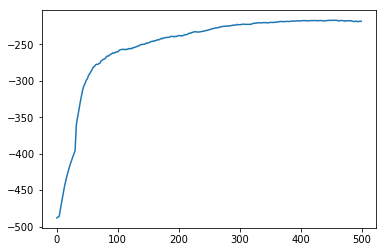

In [71]:
plt.plot(serd_train_logs['vp_lls'])

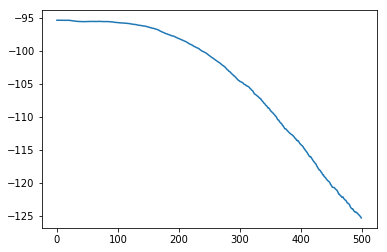

In [72]:
plt.plot(serd_train_logs['vt_lls'])

## Comparison Tests

In [73]:
def demo_stats(mdp, demos):
    demo_rewards = []
    for i in range(len(demos)):
        demo_rewards += [np.array([mdp.rewards[obs[0][2]] for obs in demos[i]])]
#         for j in range(len(demo_rewards[i])):
#             print(demos[i][j][0], demo_rewards[i][j])
    
    discounted_demo_rewards = [np.power(gamma,np.arange(len(dr)))*dr for dr in demo_rewards]
    demo_rewards, discounted_demo_rewards = np.array(demo_rewards), np.array(discounted_demo_rewards)
    data = {"mean episode reward": np.mean(np.sum(demo_rewards, axis=0)),
            "sd episode reward": np.std(np.sum(demo_rewards, axis=0)),
            "mean discounted episode reward": np.mean(np.sum(discounted_demo_rewards, axis=0)),
            "sd discounted episode reward": np.std(np.sum(discounted_demo_rewards, axis=0))}
    return data
    
    

In [74]:
SERD_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qs,temperature), n_demos, demo_time_steps)
IDL_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qi,temperature), n_demos, demo_time_steps)

In [75]:
print(demo_stats(mdp, SERD_demos))

{'mean episode reward': 0.16267362830094, 'sd episode reward': 0.023370945620867924, 'mean discounted episode reward': 0.11448377207876874, 'sd discounted episode reward': 0.036495651016342244}


In [76]:
print(demo_stats(mdp, IDL_demos))

{'mean episode reward': 0.7483403129474281, 'sd episode reward': 0.3710923657142431, 'mean discounted episode reward': 0.46080068876280594, 'sd discounted episode reward': 0.15810839143226418}


### Transfer

In [89]:
tile_map2 = [
        "2FFFFFFF1",
        "FFFFFFFFF",
        "FFFFUFFFF",
        "FFFUUUFSF",
        "FFUU3UUFF",
        "FSFUUUFSF",
        "FSFFUFFSF",
        "FFFSSSFFF",
        "1FFFFFFF2"
    ]
reward_map2, texture_map2 = build_reward_map(tile_map2, tile_rewards, goal_tile_rewards, tile_reward_modifier)
reward_normalizer2 = (1-gamma)/(np.max(reward_map2))
reward_map2 *= reward_normalizer2
time_penalty *= reward_normalizer2
temperature2 = 1/(reward_normalizer2)
print(temperature2)
print(reward_map2)
print(texture_map2)

335.4414609642231
[[0.01599123 0.00260463 0.00213188 0.00254137 0.00223742 0.00254302
  0.00244367 0.00193182 0.00698646]
 [0.00249831 0.0022532  0.00249147 0.002772   0.00215936 0.00191152
  0.00163302 0.00233368 0.00167726]
 [0.00200011 0.00185329 0.00199174 0.00266969 0.         0.00208772
  0.00208667 0.00188287 0.00193266]
 [0.00240476 0.00195253 0.00161102 0.         0.         0.
  0.0017561  0.0003342  0.00154036]
 [0.00209694 0.00204277 0.         0.         0.02       0.
  0.         0.0018915  0.00165397]
 [0.00223556 0.00039265 0.00217249 0.         0.         0.
  0.00172048 0.00031339 0.00179176]
 [0.00260464 0.00038351 0.00215594 0.00195275 0.         0.00194481
  0.00211394 0.00038269 0.00228295]
 [0.00208487 0.00260357 0.00182865 0.00035475 0.00036441 0.00032493
  0.00198136 0.00248276 0.00183929]
 [0.00729494 0.00221339 0.00151269 0.00248261 0.00283759 0.00164137
  0.0020199  0.00235424 0.01264125]]
[[3.36412278 0.87370052 0.71512175 0.85248073 0.75052438 0.85303413
 

In [80]:
mdp = MarsExplorerEnv(tile_map2, reward_map2, texture_map2, trans_dict, time_penalty) 
nA = mdp.nA
nS = mdp.nS

In [81]:
Tips = softmax(Ti_thetas,axis=1)
Ti = mdp.adt_trans_to_sas_trans(Tips)
Ri = mdp.rewards
Qit = tabsoftq_iter(Ri, Ti, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [82]:
Tsps = softmax(Ts_thetas,axis=1)
Ts = mdp.adt_trans_to_sas_trans(Tips)
Rs = mdp.feature_map.dot(Rs_thetas)
Qst = tabsoftq_iter(Rs, Ts, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [83]:
IDL_trans_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qit,temperature), n_demos, demo_time_steps)
SERD_trans_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qst,temperature), n_demos, demo_time_steps)

/Users/mckaneandrus/anaconda2/envs/irld/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


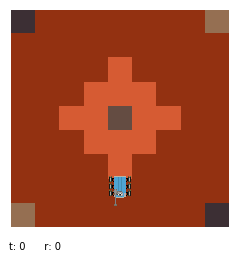

[0.56062589 0.55969527 0.55728253 0.56004278 0.54970913]
1
[0.38857049 0.24484213 0.07393445 0.29092913 0.00172381]
(4, 7) b'S'
(4, 8) b'F'


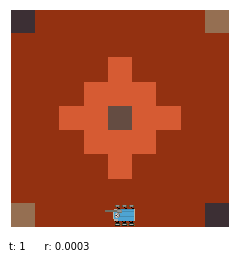

[0.57901127 0.58018551 0.55713316 0.55756939 0.5703419 ]
0
[0.35656123 0.63859778 0.00000686 0.00000852 0.00482561]
(4, 8) b'F'
(3, 8) b'F'


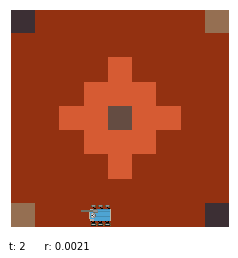

[0.5928516  0.59412288 0.56747411 0.56849923 0.58400446]
0
[0.34581026 0.64990173 0.00000117 0.00000195 0.00428489]
(3, 8) b'F'
(2, 8) b'F'


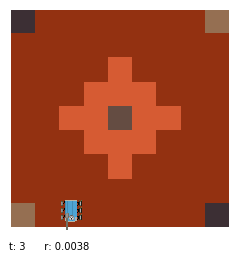

[0.60362955 0.6086415  0.57503358 0.57184309 0.59826637]
1
[0.07633658 0.91833294 0.00000005 0.00000001 0.00533042]
(2, 8) b'F'
(2, 0) b'F'


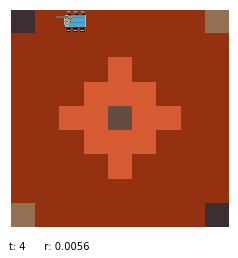

[0.65500021 0.65050892 0.61226834 0.61452367 0.64414986]
0
[0.89910238 0.09677528 0.         0.         0.00412233]
(2, 0) b'F'
(2, 8) b'F'


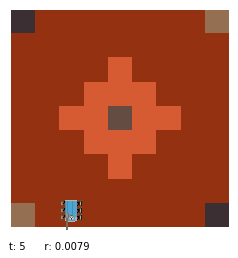

[0.60362955 0.6086415  0.57503358 0.57184309 0.59826637]
1
[0.07633658 0.91833294 0.00000005 0.00000001 0.00533042]
(2, 8) b'F'
(3, 8) b'F'


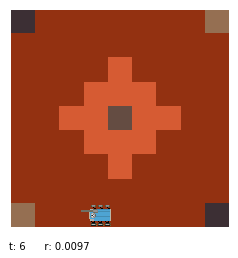

[0.5928516  0.59412288 0.56747411 0.56849923 0.58400446]
0
[0.34581026 0.64990173 0.00000117 0.00000195 0.00428489]
(3, 8) b'F'
(2, 8) b'F'


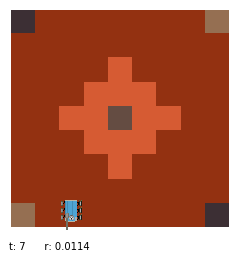

[0.60362955 0.6086415  0.57503358 0.57184309 0.59826637]
1
[0.07633658 0.91833294 0.00000005 0.00000001 0.00533042]
(2, 8) b'F'
(2, 0) b'F'


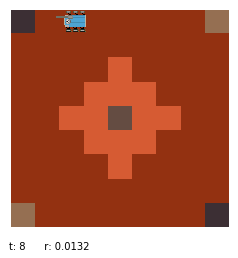

[0.65500021 0.65050892 0.61226834 0.61452367 0.64414986]
0
[0.89910238 0.09677528 0.         0.         0.00412233]
(2, 0) b'F'
(1, 0) b'F'


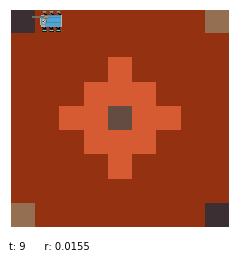

[0.67887012 0.67407245 0.63004982 0.63101409 0.66832952]
0
[0.91091354 0.08421596 0.         0.         0.0048705 ]
(1, 0) b'F'
(0, 0) b'2'


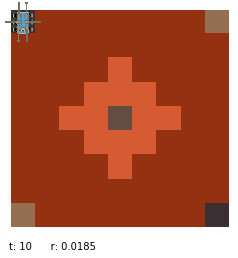

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


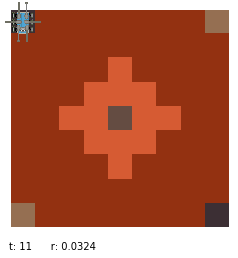

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


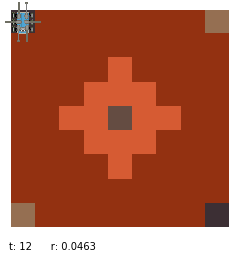

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


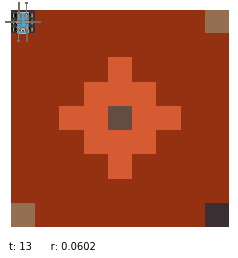

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


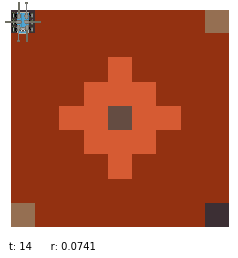

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


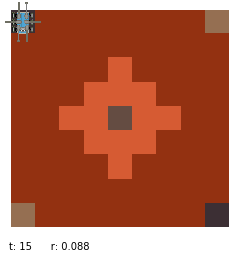

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


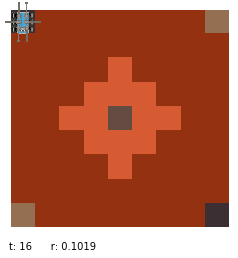

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


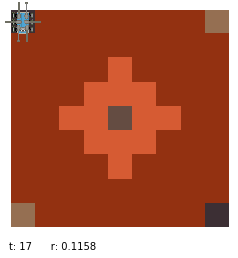

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


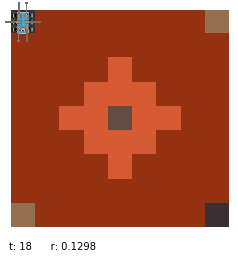

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


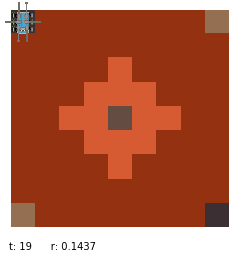

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


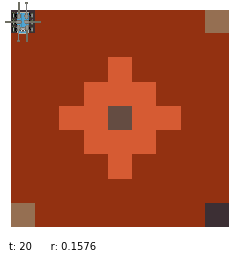

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


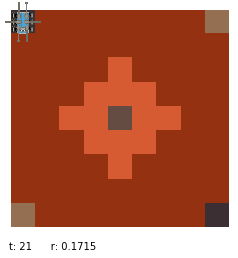

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


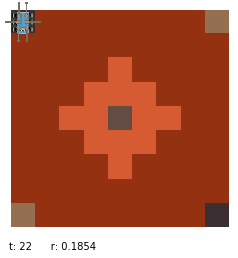

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


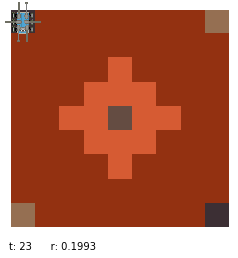

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


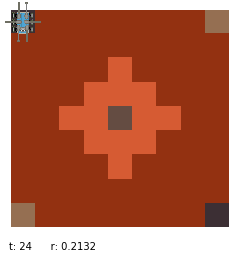

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


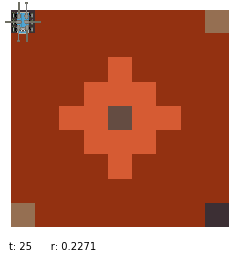

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


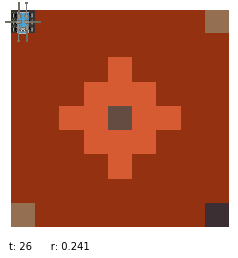

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


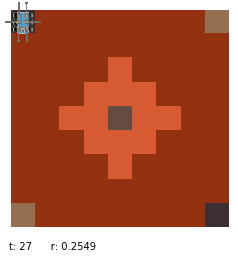

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


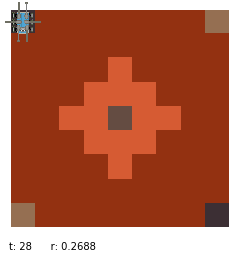

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


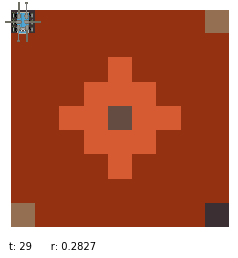

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


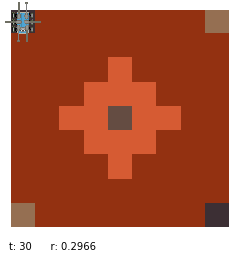

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


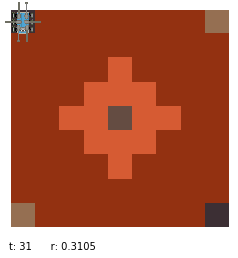

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


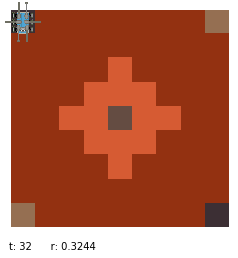

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


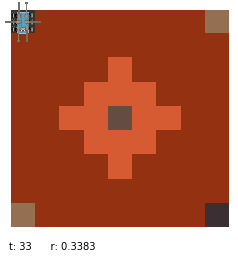

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


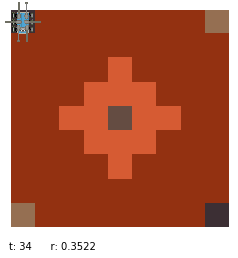

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


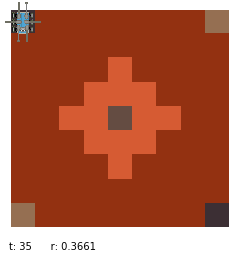

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


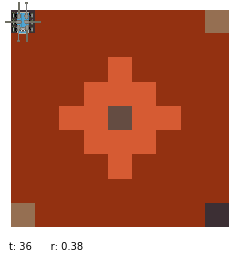

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


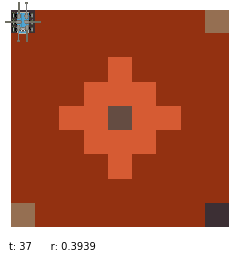

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


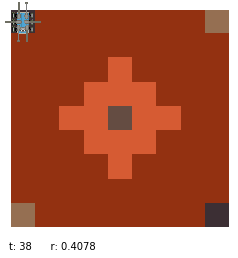

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


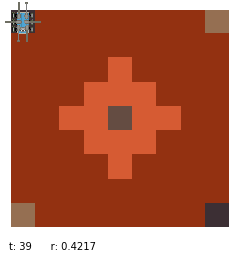

[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
4
[0.         0.00000002 0.         0.         0.99999998]
(0, 0) b'2'
(0, 0) b'2'


In [92]:
plot_mars(mdp,tabsoftq_gen_pol(Qit, temperature),Qs=Qit)

In [85]:
print(demo_stats(mdp, IDL_trans_demos))

{'mean episode reward': 0.5519815146881887, 'sd episode reward': 0.19753236616329753, 'mean discounted episode reward': 0.3559548328692203, 'sd discounted episode reward': 0.11683001194960137}


In [86]:
print(demo_stats(mdp, SERD_trans_demos))

{'mean episode reward': 0.9116731821861114, 'sd episode reward': 0.31652107726731543, 'mean discounted episode reward': 0.5911950010580358, 'sd discounted episode reward': 0.1975256842868665}


In [87]:
print(softmax(Ti_thetas))

[[[0.77917661 0.11249422]
  [0.04931367 0.08831134]
  [0.00000002 0.11682622]
  [0.17150968 0.1015057 ]
  [0.00000002 0.58086251]]

 [[0.5450258  0.11249422]
  [0.16584808 0.08831134]
  [0.28912545 0.11682622]
  [0.00000034 0.1015057 ]
  [0.00000034 0.58086251]]

 [[0.00000005 0.11249422]
  [0.03290858 0.08831134]
  [0.53053238 0.11682622]
  [0.43655894 0.1015057 ]
  [0.00000005 0.58086251]]

 [[0.19329021 0.11249422]
  [0.00000001 0.08831134]
  [0.11455897 0.11682622]
  [0.69215079 0.1015057 ]
  [0.00000001 0.58086251]]

 [[0.00000001 0.11249422]
  [0.00000001 0.08831134]
  [0.00000001 0.11682622]
  [0.00000001 0.1015057 ]
  [0.99999997 0.58086251]]]


In [88]:
print(softmax(Ts_thetas))

[[[0.31980844 0.20819031]
  [0.16867481 0.18969804]
  [0.00000003 0.16342204]
  [0.51151668 0.15640062]
  [0.00000003 0.28228899]]

 [[0.19470682 0.20819031]
  [0.64181128 0.18969804]
  [0.16348128 0.16342204]
  [0.00000031 0.15640062]
  [0.00000031 0.28228899]]

 [[0.00000005 0.20819031]
  [0.0837786  0.18969804]
  [0.84659632 0.16342204]
  [0.06962499 0.15640062]
  [0.00000005 0.28228899]]

 [[0.05687259 0.20819031]
  [0.00000001 0.18969804]
  [0.04371611 0.16342204]
  [0.89941129 0.15640062]
  [0.00000001 0.28228899]]

 [[0.00000001 0.20819031]
  [0.00000001 0.18969804]
  [0.00000001 0.16342204]
  [0.00000001 0.15640062]
  [0.99999997 0.28228899]]]


In [93]:
print(Qit)

[[0.64777988 0.65994791 0.64737323 0.63194669 0.69523358]
 [0.67887012 0.67407245 0.63004982 0.63101409 0.66832952]
 [0.65500021 0.65050892 0.61226834 0.61452367 0.64414986]
 [0.63296237 0.62903869 0.59496378 0.5976947  0.62196401]
 [0.61251934 0.60943552 0.57969139 0.58205713 0.60202769]
 [0.5944949  0.59521651 0.57360015 0.57109315 0.58550602]
 [0.5815396  0.59347255 0.58718343 0.57075832 0.5831586 ]
 [0.58409446 0.60928137 0.61889813 0.58756442 0.60894895]
 [0.61208921 0.6406443  0.6589505  0.62340887 0.65244458]
 [0.65741109 0.65151981 0.6732558  0.68200556 0.6699943 ]
 [0.66826896 0.65697374 0.65329992 0.66560158 0.65669536]
 [0.65315419 0.6432827  0.6342545  0.64454913 0.64170805]
 [0.63708601 0.62837867 0.61543118 0.62440746 0.6264677 ]
 [0.62023175 0.6101631  0.59713127 0.60581531 0.60997995]
 [0.60453743 0.60078886 0.58928276 0.5910576  0.59385379]
 [0.59210458 0.60166534 0.60305007 0.58943281 0.59267273]
 [0.59671389 0.61334559 0.63083426 0.61046425 0.61988152]
 [0.62632947 0